# Dataset Loading

In [ ]:
!kaggle datasets download -d bogdanpetre98/aadb-imagedatabase

Dataset URL: https://www.kaggle.com/datasets/bogdanpetre98/aadb-imagedatabase
License(s): unknown
aadb-imagedatabase.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
import os
File = 'aadb-imagedatabase.zip'
# Unzipping the file
with zipfile.ZipFile(File, 'r') as zip_ref:
    zip_ref.extractall('AADB Dataset')

# List the contents of the extracted directory
os.listdir('AADB Dataset')

['Dataset_test.csv', 'datasetImages_warp256', 'Dataset.csv']

In [ ]:
import pandas as pd

data = pd.read_csv('/content/AADB Dataset/Dataset.csv')
data.head()

ImageFile  BalacingElements  ColorHarmony  \
0  farm1_333_19438364933_087c8abc60_b.jpg              -0.2           0.2   
1  farm1_452_19898743300_201156d984_b.jpg               0.2           0.4   
2  farm1_281_20247100976_c8141d3653_b.jpg              -0.2           0.0   
3  farm1_448_19709457333_be4c6bb5eb_b.jpg               0.0           0.6   
4  farm1_393_20179744375_c119001350_b.jpg              -0.2           0.6   

   Content  DoF  Light  MotionBlur  Object  Repetition  RuleOfThirds  \
0     -0.2 -0.4    0.0         0.0    -0.4         0.0          -0.2   
1      0.6 -0.2    0.2         0.0     0.6         0.0           0.8   
2      0.4 -0.2   -0.4         0.0    -0.6         0.0          -0.4   
3     -0.6 -0.2    0.0         0.0     0.2         0.2           0.0   
4      0.4  0.0   -0.4         0.0     0.2         0.0           0.0   

   Symmetry  VividColor  score  
0       0.0         0.0   0.30  
1       0.0         0.4   0.70  
2       0.0         0.6   0.40  
3       0.0         0.4   0.60  
4       0.0         0.2   0.45

# EDA

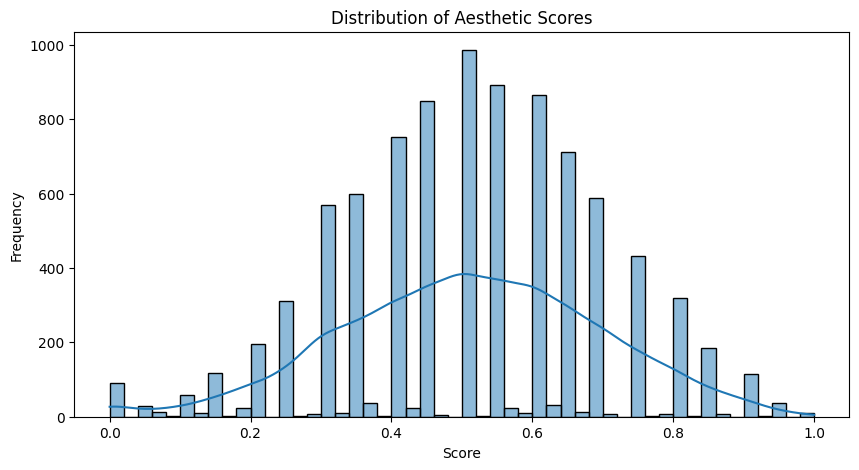

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of scores
plt.figure(figsize=(10, 5))
sns.histplot(data['score'], bins=50, kde=True)
plt.title('Distribution of Aesthetic Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

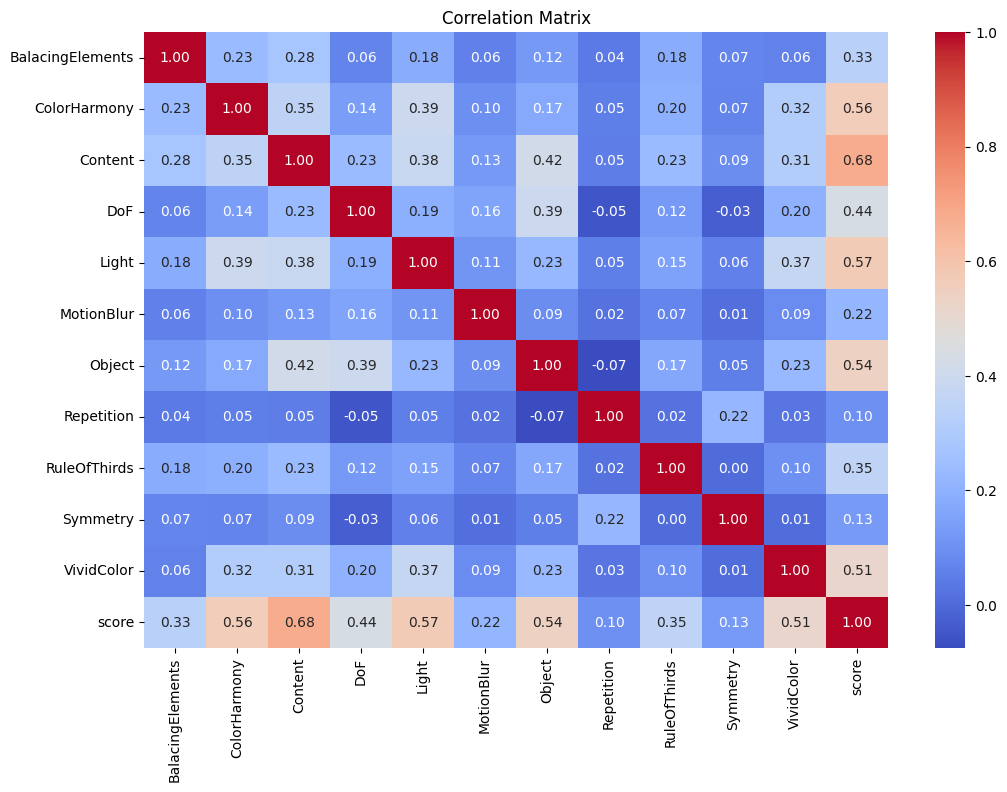

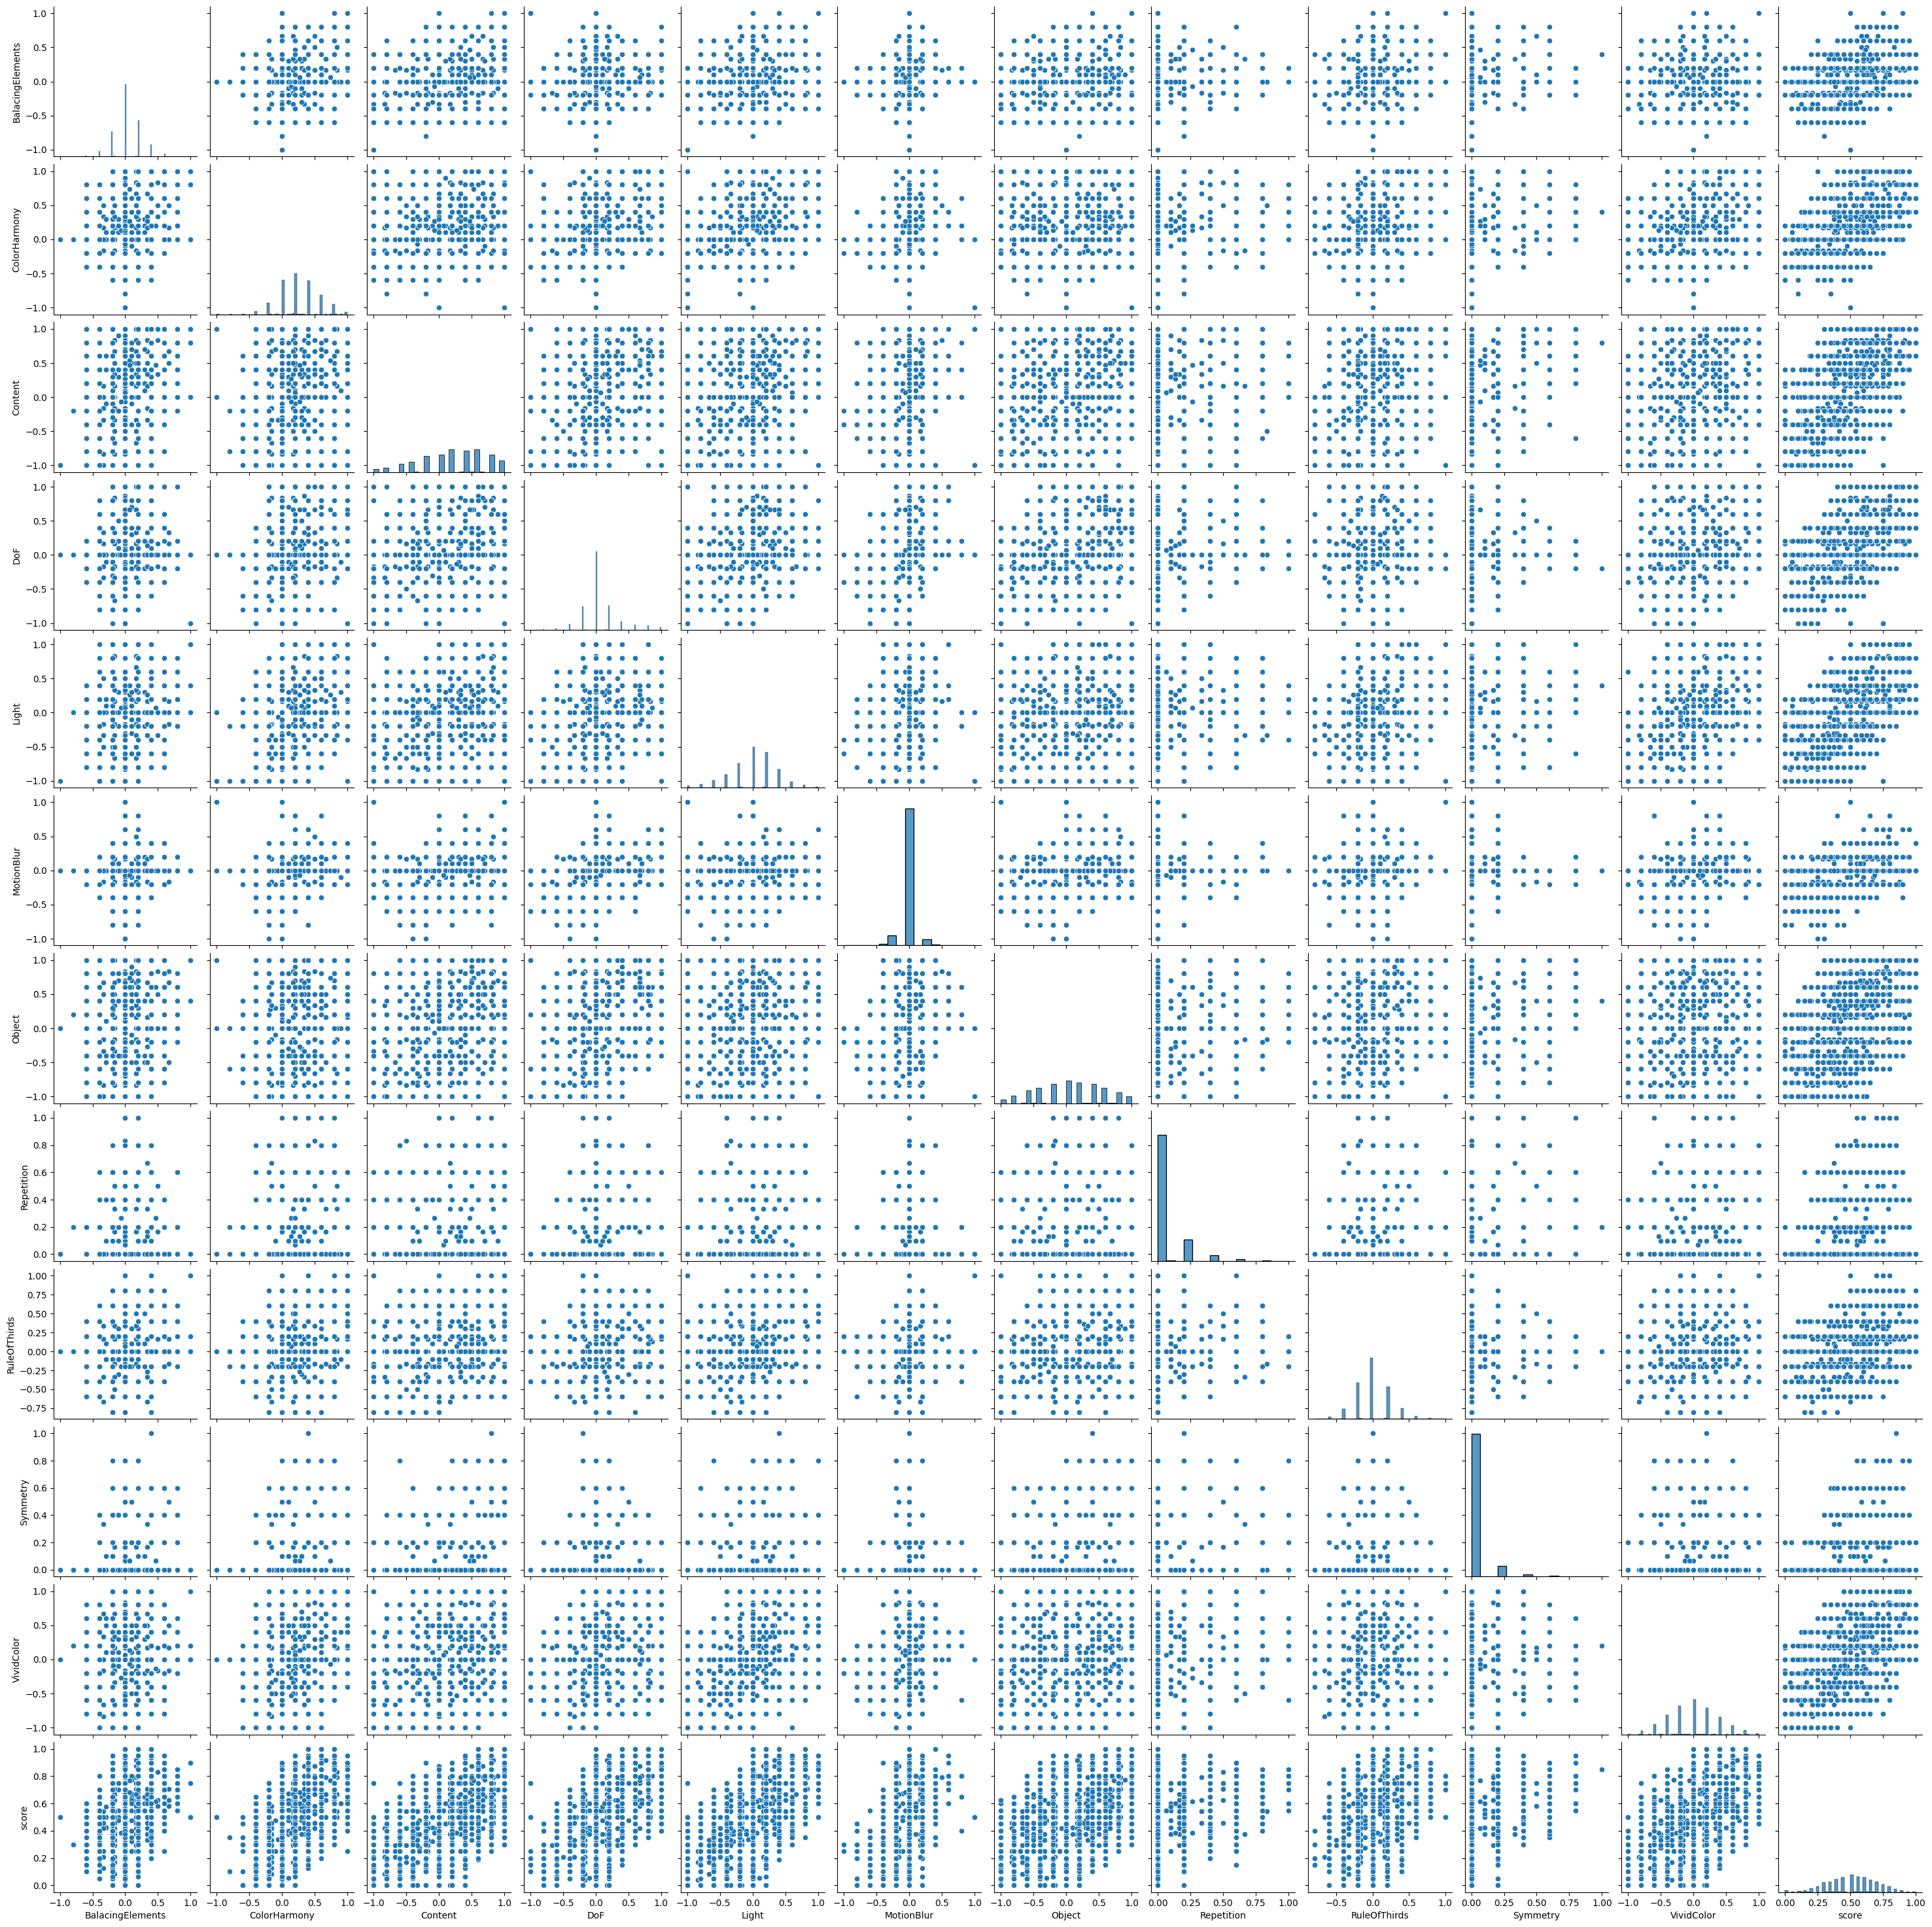

In [ ]:
# Correlation matrix excluding the 'ImageFile' column
corr_matrix = data.drop(columns=['ImageFile']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot
sns.pairplot(data.drop(columns=['ImageFile']))
plt.show()

In [ ]:
# Define the path to the image folder
image_folder = '/content/AADB Dataset/datasetImages_warp256/datasetImages_warp256'

In [ ]:
import tensorflow as tf
# Define the image size
image_size = (224, 224)

# Preprocess the images
def preprocess_image(image_name, label):
    image_path = os.path.join(image_folder, image_name.numpy().decode('utf-8'))
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image /= 255.0
    return image, tf.cast(label, tf.float32)

In [ ]:
def preprocess_image(image_path, label):
    """Preprocess image and normalize label"""
    # Read the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, tf.cast(label, tf.float32)

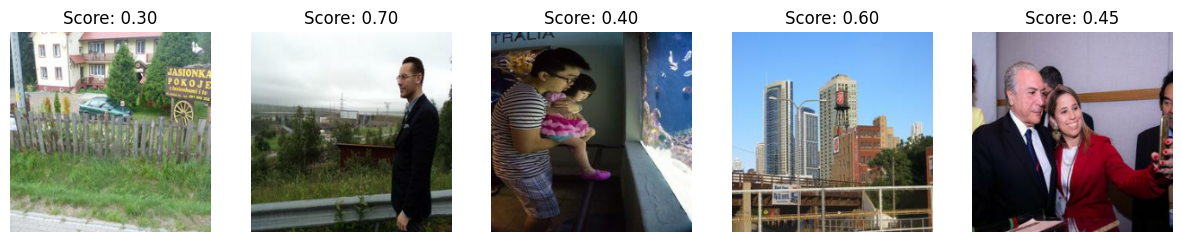

In [ ]:
import matplotlib.pyplot as plt

# Function to preprocess and load images
def load_and_preprocess_image(image_name):
    image_path = os.path.join(image_folder, image_name)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image /= 255.0  
    return image


def visualize_images(data, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        image_name = data['ImageFile'].iloc[i]
        label = data['score'].iloc[i]
        image = load_and_preprocess_image(image_name)

        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(f'Score: {label:.2f}')
        plt.axis('off')
    plt.show()


visualize_images(data, num_images=5)

# Model Building

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model


base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)


model = Model(inputs, predictions)


model.compile(optimizer='adam', loss='mean_absolute_error')

219055592/219055592 [==============================] - 11s 0us/step


In [ ]:
!pip install pydot graphviz

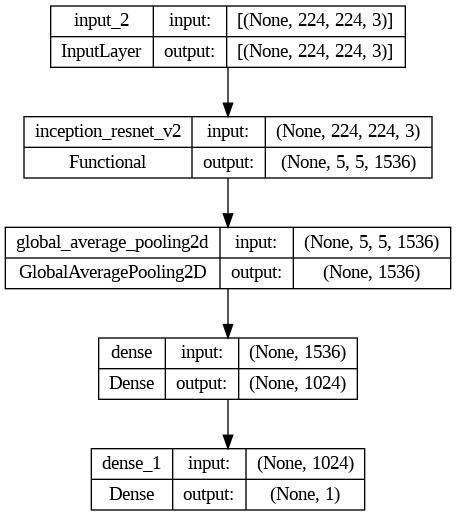

In [ ]:
from tensorflow.keras.utils import plot_model


plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image('model_architecture.png')


In [ ]:

def create_dataset(dataframe):
    image_paths = dataframe['ImageFile'].values
    labels = dataframe['score'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: tf.py_function(func=preprocess_image, inp=[x, y], Tout=[tf.float32, tf.float32]))
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)

In [ ]:
for data, labels in train_dataset.take(1):
    print(data.shape, labels.shape)

(32, 224, 224, 3) (32,)


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0


# Training and evaluation

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
224/224 [==============================] - 109s 417ms/step - loss: 0.3848 - val_loss: 0.1525
Epoch 2/10
224/224 [==============================] - 78s 348ms/step - loss: 0.1393 - val_loss: 0.1443
Epoch 3/10
224/224 [==============================] - 84s 374ms/step - loss: 0.1328 - val_loss: 0.1408
Epoch 4/10
224/224 [==============================] - 77s 343ms/step - loss: 0.1270 - val_loss: 0.1417
Epoch 5/10
224/224 [==============================] - 82s 367ms/step - loss: 0.1236 - val_loss: 0.1403
Epoch 6/10
224/224 [==============================] - 77s 343ms/step - loss: 0.1207 - val_loss: 0.1359
Epoch 7/10
224/224 [==============================] - 77s 344ms/step - loss: 0.1201 - val_loss: 0.1358
Epoch 8/10
224/224 [==============================] - 83s 369ms/step - loss: 0.1170 - val_loss: 0.1309
Epoch 9/10
224/224 [==============================] - 78s 346ms/step - loss: 0.1187 - val_loss: 0.1298
Epoch 10/10
224/224 [==============================] - 77s 342ms/step - 

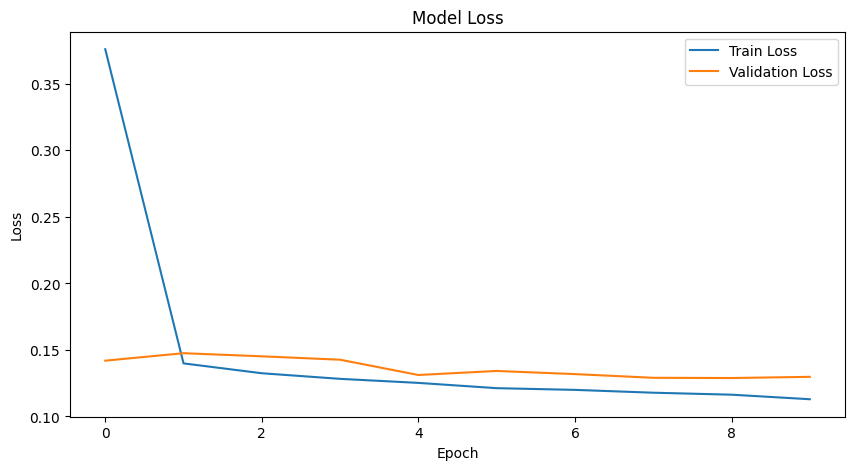

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

56/56 [==============================] - 18s 270ms/step
Mean Absolute Error (MAE): 0.13026241958141327
Mean Squared Error (MSE): 0.027200505137443542


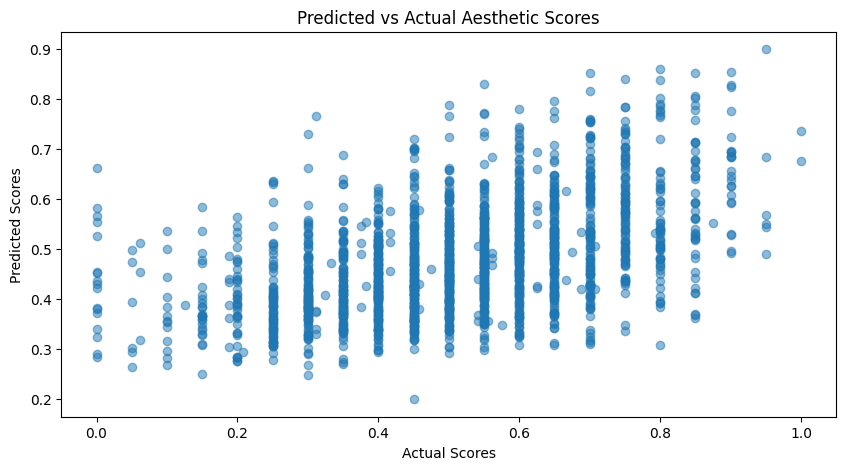

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
val_predictions = model.predict(val_dataset)

# Extract actual values from the dataset
val_labels = []
for images, labels in val_dataset:
    val_labels.extend(labels.numpy())

# Convert to numpy arrays for easier handling
val_labels = np.array(val_labels)
val_predictions = np.array(val_predictions).flatten()
mae = mean_absolute_error(val_labels, val_predictions)
mse = mean_squared_error(val_labels, val_predictions)


    # Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
# Plot predictions vs actual
plt.figure(figsize=(10, 5))
plt.scatter(val_labels, val_predictions, alpha=0.5)
plt.title('Predicted vs Actual Aesthetic Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.show()

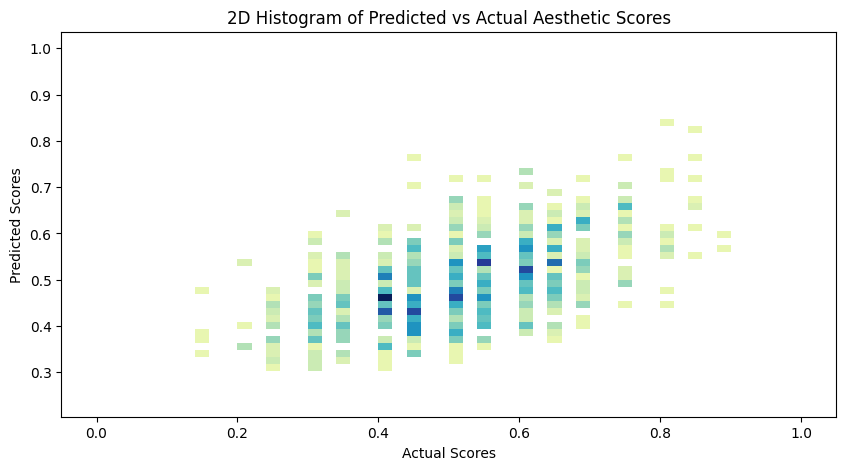

In [ ]:
import seaborn as sns

# Create a 2D histogram
plt.figure(figsize=(10, 5))
sns.histplot(x=val_labels, y=val_predictions, bins=50, pthresh=.1, cmap="YlGnBu")
plt.title('2D Histogram of Predicted vs Actual Aesthetic Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.show()


In [ ]:

model.save('/content/drive/MyDrive/aesthetic_model.keras')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

model = tf.keras.models.load_model('/content/drive/MyDrive/aesthetic/aesthetic_model.h5')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('aesthetic_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50, Xception, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

input_shape = (224, 224, 3)


def create_model(base_model):
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='linear')(x)
    return Model(inputs, predictions)

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_model = create_model(resnet_base)
resnet_model.compile(optimizer='adam', loss='mean_absolute_error')



94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
history = resnet_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
224/224 [==============================] - 70s 274ms/step - loss: 0.2864 - val_loss: 0.1449
Epoch 2/10
224/224 [==============================] - 68s 305ms/step - loss: 0.1932 - val_loss: 0.2154
Epoch 3/10
224/224 [==============================] - 67s 299ms/step - loss: 0.1854 - val_loss: 0.1689
Epoch 4/10
224/224 [==============================] - 67s 301ms/step - loss: 0.1726 - val_loss: 0.1433
Epoch 5/10
224/224 [==============================] - 67s 301ms/step - loss: 0.1676 - val_loss: 0.1478
Epoch 6/10
224/224 [==============================] - 67s 299ms/step - loss: 0.1571 - val_loss: 0.1421
Epoch 7/10
224/224 [==============================] - 59s 265ms/step - loss: 0.1553 - val_loss: 0.1635
Epoch 8/10
224/224 [==============================] - 58s 259ms/step - loss: 0.1619 - val_loss: 0.1626
Epoch 9/10
224/224 [==============================] - 67s 300ms/step - loss: 0.1510 - val_loss: 0.1632
Epoch 10/10
224/224 [==============================] - 58s 257ms/step - l

In [ ]:
resnet_model.save('/aesthetic_resnet_model.keras')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, train_dataset, val_dataset, history,epochs=10):

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

    val_predictions = model.predict(val_dataset)

    val_labels = []
    for _, labels in val_dataset:
        val_labels.extend(labels.numpy())

    val_labels = np.array(val_labels)
    val_predictions = np.array(val_predictions).flatten()


    mae = mean_absolute_error(val_labels, val_predictions)
    mse = mean_squared_error(val_labels, val_predictions)



    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")


    plt.figure(figsize=(10, 5))
    plt.scatter(val_labels, val_predictions, alpha=0.5)
    plt.title('Predicted vs Actual Scores')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.show()


    plt.figure(figsize=(10, 5))
    sns.histplot(x=val_labels, y=val_predictions, bins=50, pthresh=.1, cmap="YlGnBu")
    plt.title('2D Histogram of Predicted vs Actual Scores')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.show()




Epoch 1/10
224/224 [==============================] - 58s 259ms/step - loss: 0.1483 - val_loss: 0.1503
Epoch 2/10
224/224 [==============================] - 58s 259ms/step - loss: 0.1505 - val_loss: 0.1453
Epoch 3/10
224/224 [==============================] - 58s 258ms/step - loss: 0.1455 - val_loss: 0.1447
Epoch 4/10
224/224 [==============================] - 58s 260ms/step - loss: 0.1448 - val_loss: 0.1435
Epoch 5/10
224/224 [==============================] - 67s 299ms/step - loss: 0.1444 - val_loss: 0.1437
Epoch 6/10
224/224 [==============================] - 58s 257ms/step - loss: 0.1447 - val_loss: 0.1500
Epoch 7/10
224/224 [==============================] - 58s 257ms/step - loss: 0.1445 - val_loss: 0.1446
Epoch 8/10
224/224 [==============================] - 58s 259ms/step - loss: 0.1442 - val_loss: 0.1481
Epoch 9/10
224/224 [==============================] - 67s 298ms/step - loss: 0.1446 - val_loss: 0.1499
Epoch 10/10
224/224 [==============================] - 67s 298ms/step - l

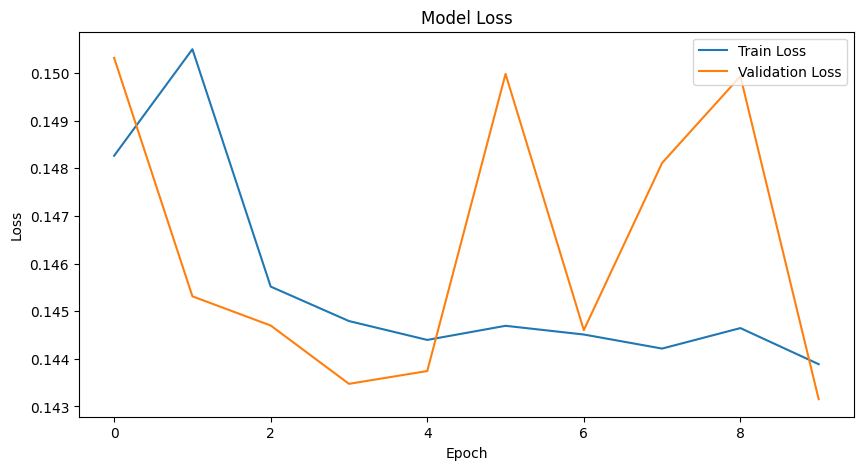

56/56 [==============================] - 11s 203ms/step
Mean Absolute Error (MAE): 0.14315056800842285
Mean Squared Error (MSE): 0.03196411579847336
R-squared (R²): 0.05648857355117798


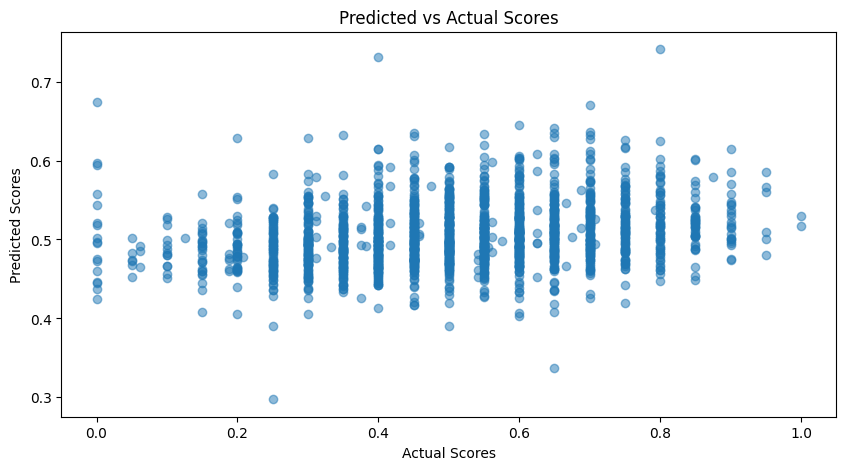

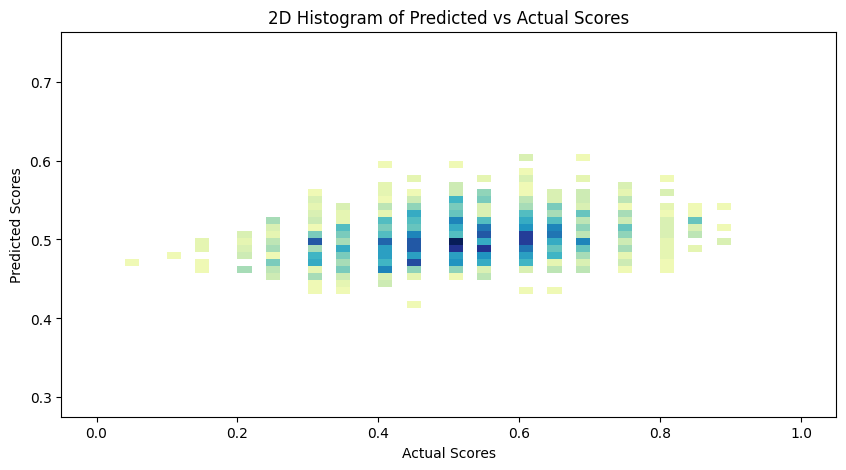

In [ ]:
evaluate_model(resnet_model, train_dataset, val_dataset, epochs=10)

In [ ]:
xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
xception_model = create_model(xception_base)
xception_model.compile(optimizer='adam', loss='mean_absolute_error')

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
 history = xception_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
224/224 [==============================] - 76s 341ms/step - loss: 0.1450 - val_loss: 0.1483
Epoch 2/10
224/224 [==============================] - 64s 285ms/step - loss: 0.1320 - val_loss: 0.1335
Epoch 3/10
224/224 [==============================] - 63s 284ms/step - loss: 0.1254 - val_loss: 0.1317
Epoch 4/10
224/224 [==============================] - 72s 320ms/step - loss: 0.1207 - val_loss: 0.1293
Epoch 5/10
224/224 [==============================] - 64s 285ms/step - loss: 0.1168 - val_loss: 0.1305
Epoch 6/10
224/224 [==============================] - 65s 290ms/step - loss: 0.1106 - val_loss: 0.1356
Epoch 7/10
224/224 [==============================] - 64s 286ms/step - loss: 0.1071 - val_loss: 0.1297
Epoch 8/10
224/224 [==============================] - 72s 322ms/step - loss: 0.1035 - val_loss: 0.1346
Epoch 9/10
224/224 [==============================] - 64s 285ms/step - loss: 0.1002 - val_loss: 0.1328
Epoch 10/10
224/224 [==============================] - 64s 286ms/step - l

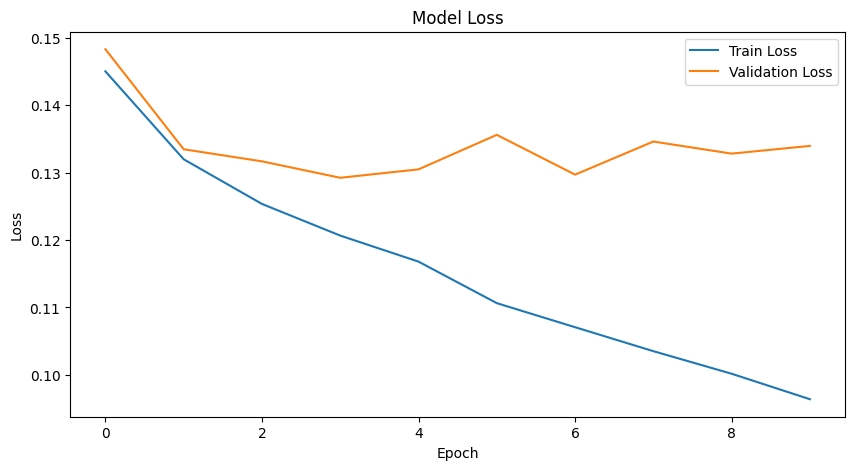

56/56 [==============================] - 13s 227ms/step
Mean Absolute Error (MAE): 0.1339838057756424
Mean Squared Error (MSE): 0.029078291729092598


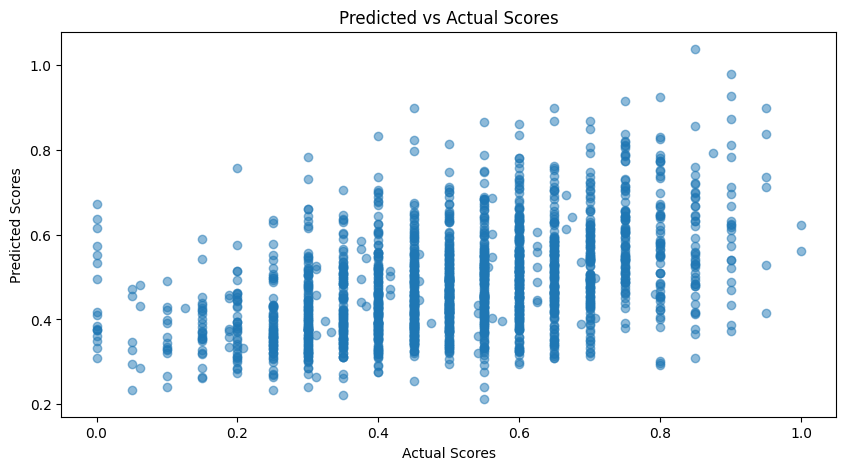

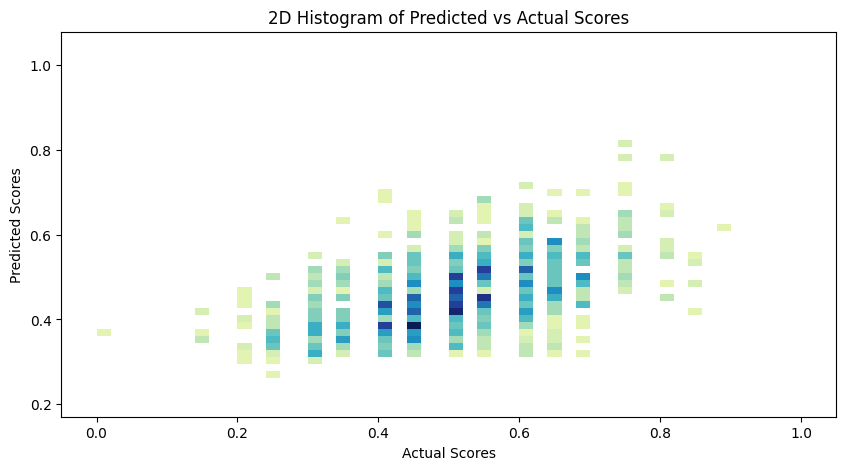

In [ ]:
evaluate_model(xception_model, train_dataset, val_dataset,history ,epochs=10)

In [ ]:
 xception_model.save('aesthetic_ xception_model.keras')

In [ ]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenet_model = create_model(mobilenet_base)
mobilenet_model.compile(optimizer='adam', loss='mean_absolute_error')

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
 history = mobilenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
224/224 [==============================] - 49s 202ms/step - loss: 0.3208 - val_loss: 0.1394
Epoch 2/10
224/224 [==============================] - 44s 197ms/step - loss: 0.1287 - val_loss: 0.1314
Epoch 3/10
224/224 [==============================] - 43s 194ms/step - loss: 0.1184 - val_loss: 0.1309
Epoch 4/10
224/224 [==============================] - 46s 205ms/step - loss: 0.1141 - val_loss: 0.1346
Epoch 5/10
224/224 [==============================] - 44s 198ms/step - loss: 0.1087 - val_loss: 0.1429
Epoch 6/10
224/224 [==============================] - 44s 197ms/step - loss: 0.1030 - val_loss: 0.1387
Epoch 7/10
224/224 [==============================] - 44s 195ms/step - loss: 0.1017 - val_loss: 0.1343
Epoch 8/10
224/224 [==============================] - 44s 196ms/step - loss: 0.0998 - val_loss: 0.1321
Epoch 9/10
224/224 [==============================] - 46s 206ms/step - loss: 0.0992 - val_loss: 0.1327
Epoch 10/10
224/224 [==============================] - 45s 201ms/step - l

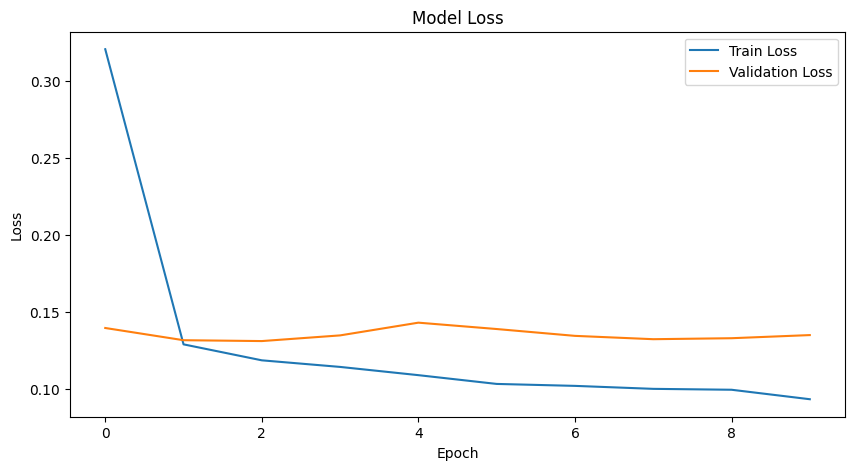

56/56 [==============================] - 9s 157ms/step
Mean Absolute Error (MAE): 0.13477550446987152
Mean Squared Error (MSE): 0.02939966320991516


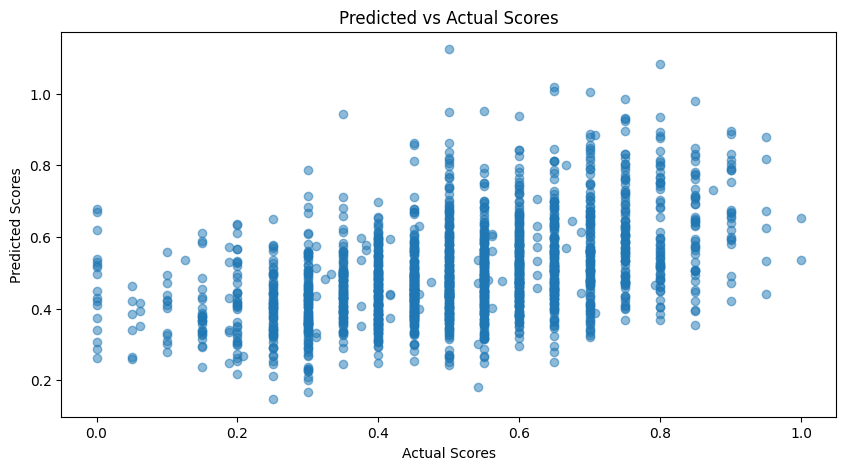

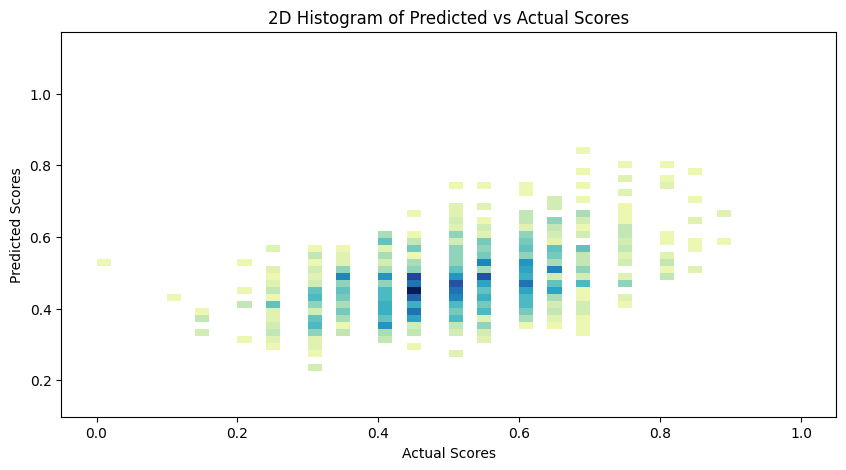

In [ ]:
evaluate_model(mobilenet_model, train_dataset, val_dataset,history ,epochs=10)

In [ ]:
mobilenet_model.save('aesthetic_ mobilenet_model.keras')

In [ ]:
from tensorflow.keras.applications import DenseNet121, EfficientNetB0, VGG16

In [ ]:
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_model = create_model(densenet_base)
densenet_model.compile(optimizer='adam', loss='mean_absolute_error')

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
history = densenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
224/224 [==============================] - 83s 319ms/step - loss: 0.3192 - val_loss: 0.1357
Epoch 2/10
224/224 [==============================] - 65s 292ms/step - loss: 0.1273 - val_loss: 0.1298
Epoch 3/10
224/224 [==============================] - 65s 291ms/step - loss: 0.1191 - val_loss: 0.1362
Epoch 4/10
224/224 [==============================] - 65s 289ms/step - loss: 0.1131 - val_loss: 0.1304
Epoch 5/10
224/224 [==============================] - 55s 245ms/step - loss: 0.1105 - val_loss: 0.1338
Epoch 6/10
224/224 [==============================] - 65s 291ms/step - loss: 0.1074 - val_loss: 0.1274
Epoch 7/10
224/224 [==============================] - 55s 247ms/step - loss: 0.1045 - val_loss: 0.1375
Epoch 8/10
224/224 [==============================] - 65s 290ms/step - loss: 0.1038 - val_loss: 0.1348
Epoch 9/10
224/224 [==============================] - 56s 249ms/step - loss: 0.1039 - val_loss: 0.1281
Epoch 10/10
224/224 [==============================] - 55s 246ms/step - l

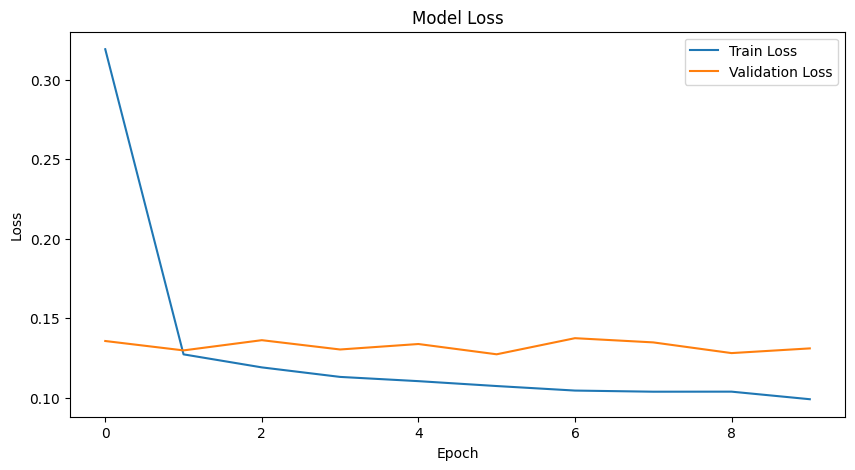

56/56 [==============================] - 30s 375ms/step
Mean Absolute Error (MAE): 0.13107188045978546
Mean Squared Error (MSE): 0.0275938268750906


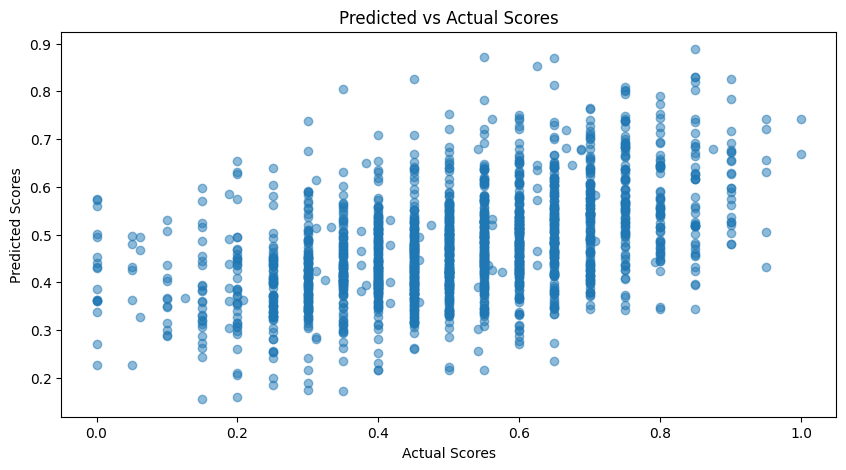

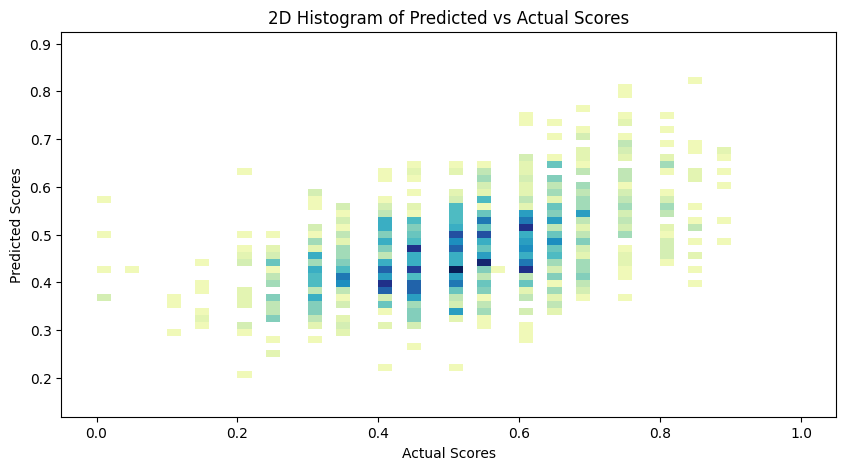

In [ ]:
evaluate_model(densenet_model, train_dataset, val_dataset,history ,epochs=10)

In [ ]:
densenet_model.save('aesthetic_densnet_model.keras')

In [ ]:
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
efficientnet_model = create_model(efficientnet_base)
efficientnet_model.compile(optimizer='adam', loss='mean_absolute_error')

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
history = efficientnet_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
224/224 [==============================] - 66s 259ms/step - loss: 0.2144 - val_loss: 0.1490
Epoch 2/10
224/224 [==============================] - 49s 220ms/step - loss: 0.1624 - val_loss: 0.1660
Epoch 3/10
224/224 [==============================] - 51s 228ms/step - loss: 0.1577 - val_loss: 0.1595
Epoch 4/10
224/224 [==============================] - 49s 217ms/step - loss: 0.1507 - val_loss: 0.1476
Epoch 5/10
224/224 [==============================] - 50s 223ms/step - loss: 0.1510 - val_loss: 0.1487
Epoch 6/10
224/224 [==============================] - 49s 220ms/step - loss: 0.1503 - val_loss: 0.1487
Epoch 7/10
224/224 [==============================] - 47s 211ms/step - loss: 0.1495 - val_loss: 0.1489
Epoch 8/10
224/224 [==============================] - 49s 218ms/step - loss: 0.1497 - val_loss: 0.1490
Epoch 9/10
224/224 [==============================] - 47s 212ms/step - loss: 0.1491 - val_loss: 0.1490
Epoch 10/10
224/224 [==============================] - 48s 215ms/step - l

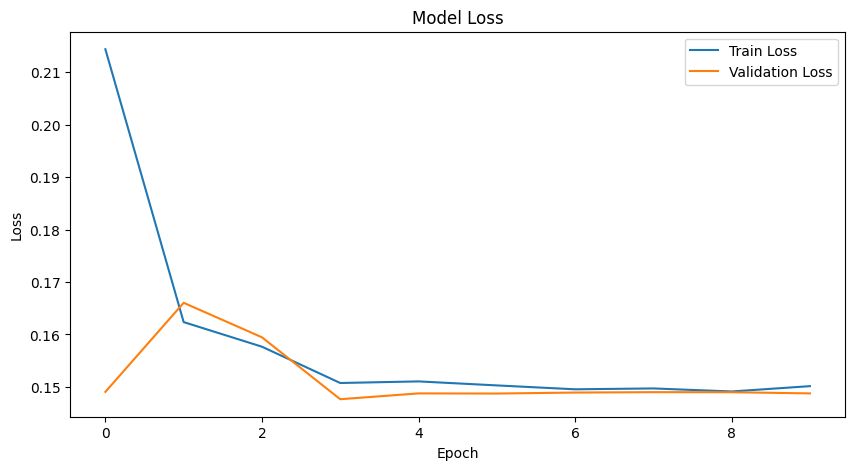

56/56 [==============================] - 12s 160ms/step
Mean Absolute Error (MAE): 0.14875173568725586
Mean Squared Error (MSE): 0.034407585859298706


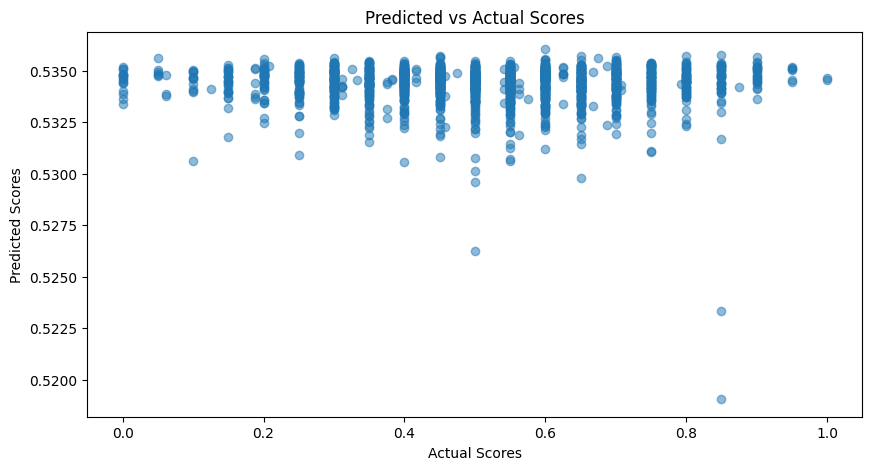

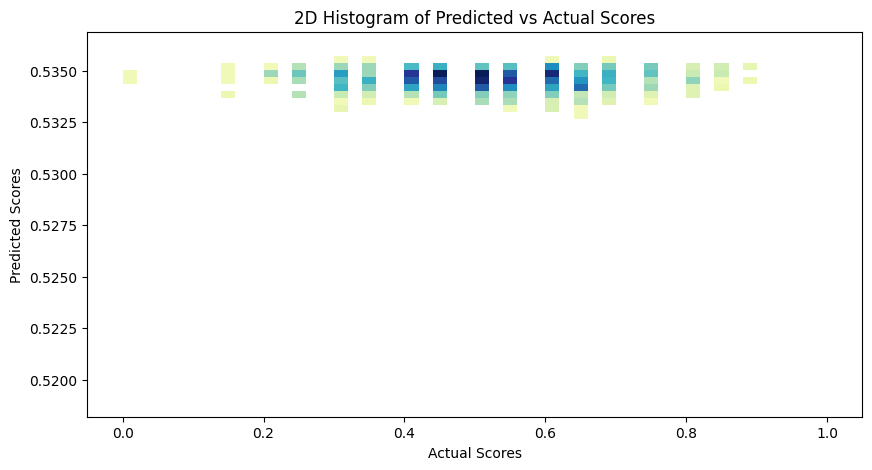

In [ ]:
evaluate_model(efficientnet_model, train_dataset, val_dataset,history ,epochs=10)

In [ ]:
efficientnet_model.save('/content/drive/MyDrive/aesthetic_efficient_model.keras')

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_model = create_model(vgg_base)
vgg_model.compile(optimizer='adam', loss='mean_absolute_error')

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
history = vgg_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
224/224 [==============================] - 74s 330ms/step - loss: 0.1615 - val_loss: 0.1827
Epoch 2/10
224/224 [==============================] - 65s 288ms/step - loss: 0.1469 - val_loss: 0.1373
Epoch 3/10
224/224 [==============================] - 63s 282ms/step - loss: 0.1417 - val_loss: 0.2068
Epoch 4/10
224/224 [==============================] - 64s 284ms/step - loss: 0.1451 - val_loss: 0.1329
Epoch 5/10
224/224 [==============================] - 64s 286ms/step - loss: 0.1359 - val_loss: 0.1318
Epoch 6/10
224/224 [==============================] - 63s 282ms/step - loss: 0.1318 - val_loss: 0.1354
Epoch 7/10
224/224 [==============================] - 71s 317ms/step - loss: 0.1310 - val_loss: 0.1302
Epoch 8/10
224/224 [==============================] - 64s 285ms/step - loss: 0.1272 - val_loss: 0.1292
Epoch 9/10
224/224 [==============================] - 72s 322ms/step - loss: 0.1273 - val_loss: 0.1320
Epoch 10/10
224/224 [==============================] - 74s 332ms/step - l

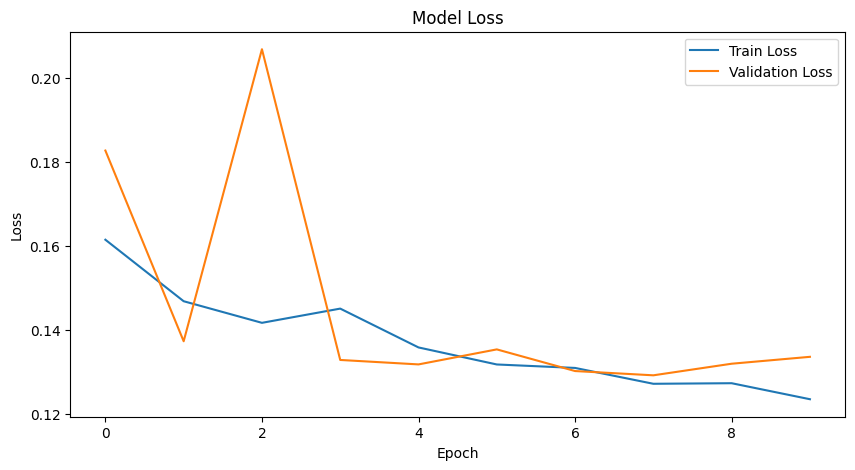

56/56 [==============================] - 14s 256ms/step
Mean Absolute Error (MAE): 0.1336248368024826
Mean Squared Error (MSE): 0.028330083936452866


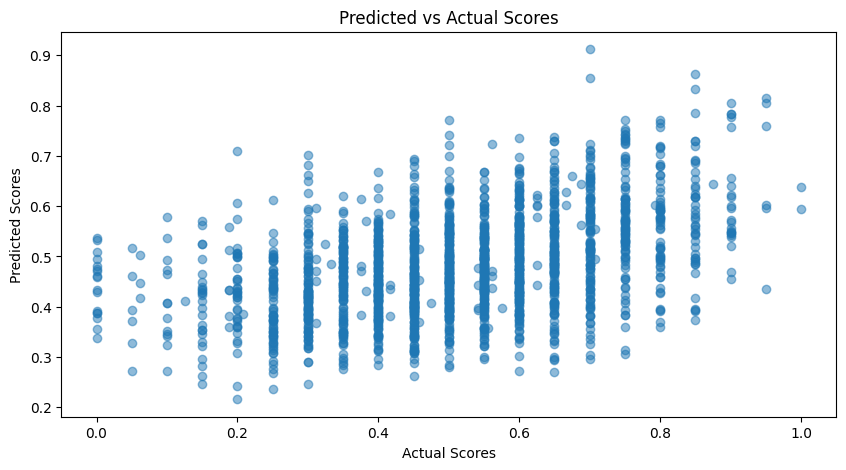

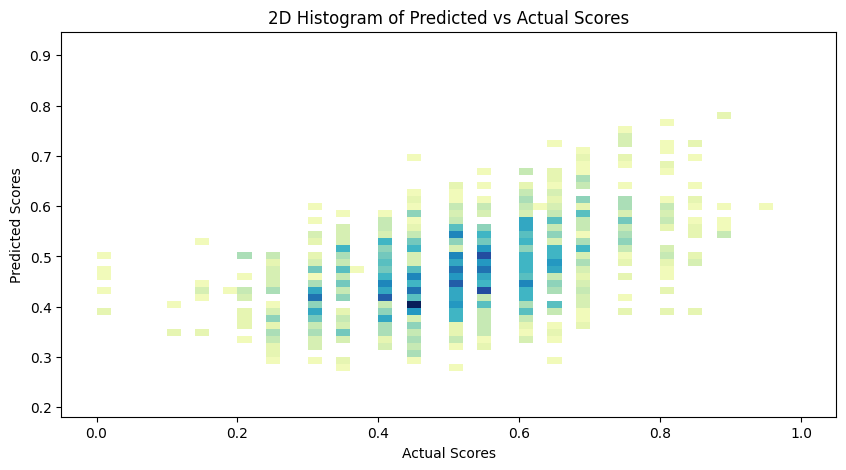

In [ ]:
evaluate_model(vgg_model, train_dataset, val_dataset,history ,epochs=10)

In [ ]:
vgg_model.save('/content/drive/MyDrive/aesthetic_vgg_model.keras')

56/56 [==============================] - 9s 170ms/step
Ensemble Mean Absolute Error (MAE): 0.1249919980764389
Ensemble Mean Squared Error (MSE): 0.024966442957520485


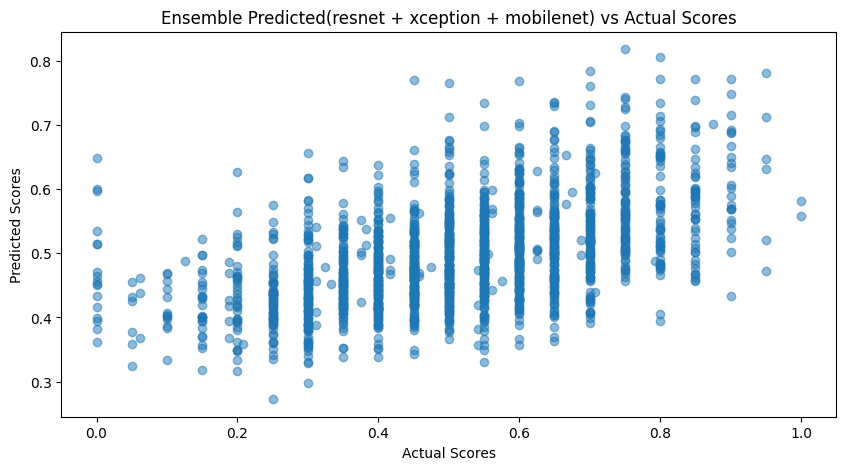

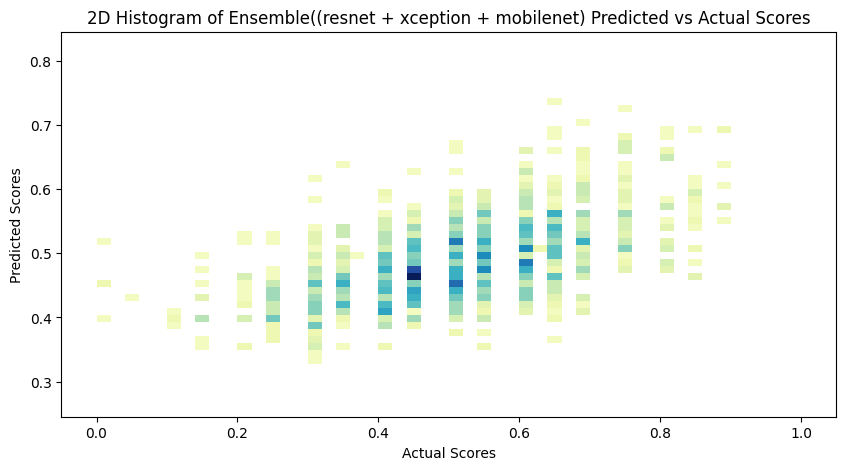

In [ ]:
def ensemble_predict(models, dataset):
    all_predictions = []


    for model in models:
        predictions = model.predict(dataset)
        all_predictions.append(predictions.flatten())


    ensemble_predictions = np.mean(np.stack(all_predictions, axis=0), axis=0)
    return ensemble_predictions


models = [resnet_model, xception_model, mobilenet_model]


ensemble_val_predictions = ensemble_predict(models, val_dataset)


val_labels = []
for _, labels in val_dataset:
    val_labels.extend(labels.numpy())

val_labels = np.array(val_labels)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(val_labels, ensemble_val_predictions)
mse = mean_squared_error(val_labels, ensemble_val_predictions)


print(f"Ensemble Mean Absolute Error (MAE): {mae}")
print(f"Ensemble Mean Squared Error (MSE): {mse}")


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(val_labels, ensemble_val_predictions, alpha=0.5)
plt.title('Ensemble Predicted(resnet + xception + mobilenet) vs Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.show()


import seaborn as sns
plt.figure(figsize=(10, 5))
sns.histplot(x=val_labels, y=ensemble_val_predictions, bins=50, pthresh=.1, cmap="YlGnBu")
plt.title('2D Histogram of Ensemble((resnet + xception + mobilenet) Predicted vs Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.show()

56/56 [==============================] - 13s 231ms/step
Ensemble Mean Absolute Error (MAE): 0.12799830734729767
Ensemble Mean Squared Error (MSE): 0.02586793340742588


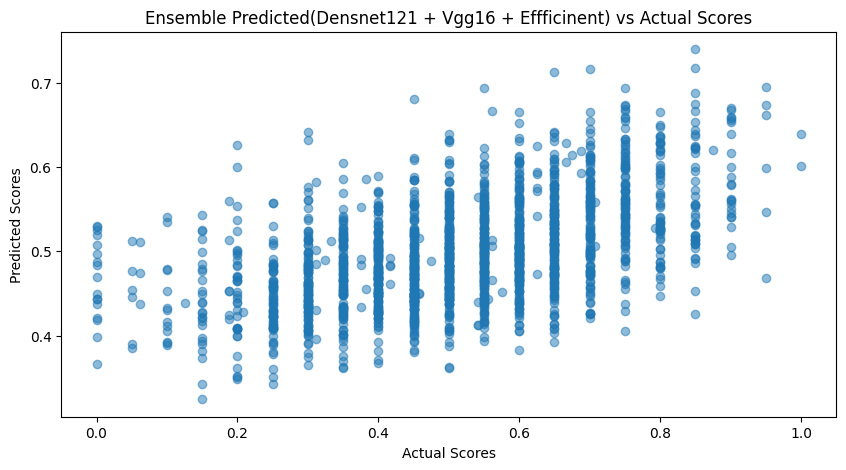

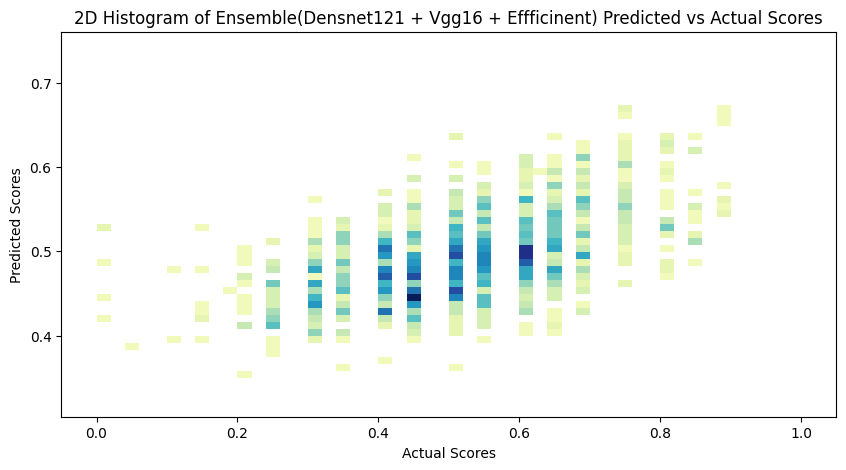

In [ ]:
models = [densenet_model, efficientnet_model, vgg_model]


ensemble_val_predictions = ensemble_predict(models, val_dataset)


val_labels = []
for _, labels in val_dataset:
    val_labels.extend(labels.numpy())

val_labels = np.array(val_labels)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(val_labels, ensemble_val_predictions)
mse = mean_squared_error(val_labels, ensemble_val_predictions)


print(f"Ensemble Mean Absolute Error (MAE): {mae}")
print(f"Ensemble Mean Squared Error (MSE): {mse}")


# Plot Predicted vs Actual values (Scatter plot)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(val_labels, ensemble_val_predictions, alpha=0.5)
plt.title('Ensemble Predicted(Densnet121 + Vgg16 + Effficinent) vs Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.show()

# Create a 2D Histogram of Predicted vs Actual values
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.histplot(x=val_labels, y=ensemble_val_predictions, bins=50, pthresh=.1, cmap="YlGnBu")
plt.title('2D Histogram of Ensemble(Densnet121 + Vgg16 + Effficinent) Predicted vs Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.show()

56/56 [==============================] - 16s 284ms/step
Ensemble Mean Absolute Error (MAE): 0.1234871968626976
Ensemble Mean Squared Error (MSE): 0.024220824241638184


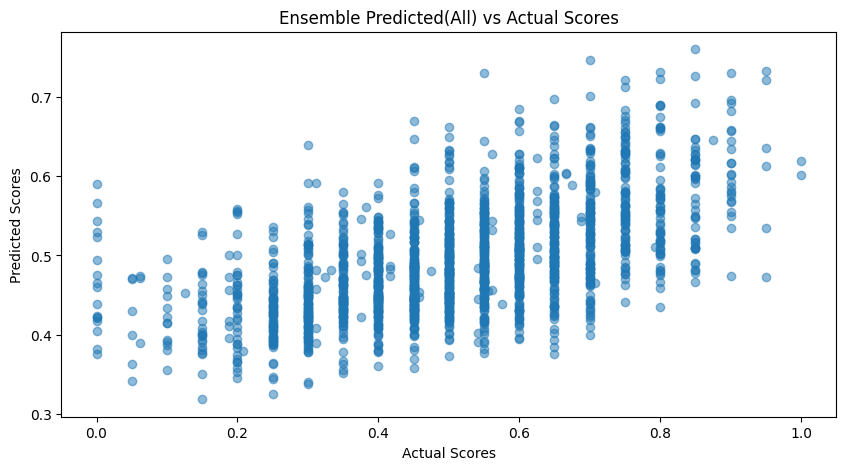

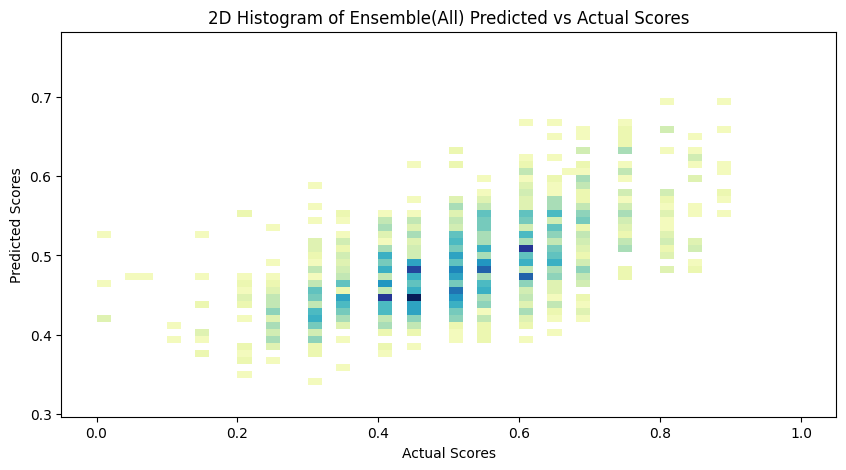

In [ ]:
models = [densenet_model, efficientnet_model, vgg_model,resnet_model, xception_model, mobilenet_model,model]


ensemble_val_predictions = ensemble_predict(models, val_dataset)


val_labels = []
for _, labels in val_dataset:
    val_labels.extend(labels.numpy())

val_labels = np.array(val_labels)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(val_labels, ensemble_val_predictions)
mse = mean_squared_error(val_labels, ensemble_val_predictions)


print(f"Ensemble Mean Absolute Error (MAE): {mae}")
print(f"Ensemble Mean Squared Error (MSE): {mse}")



import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(val_labels, ensemble_val_predictions, alpha=0.5)
plt.title('Ensemble Predicted(All) vs Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.show()


import seaborn as sns
plt.figure(figsize=(10, 5))
sns.histplot(x=val_labels, y=ensemble_val_predictions, bins=50, pthresh=.1, cmap="YlGnBu")
plt.title('2D Histogram of Ensemble(All) Predicted vs Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.show()

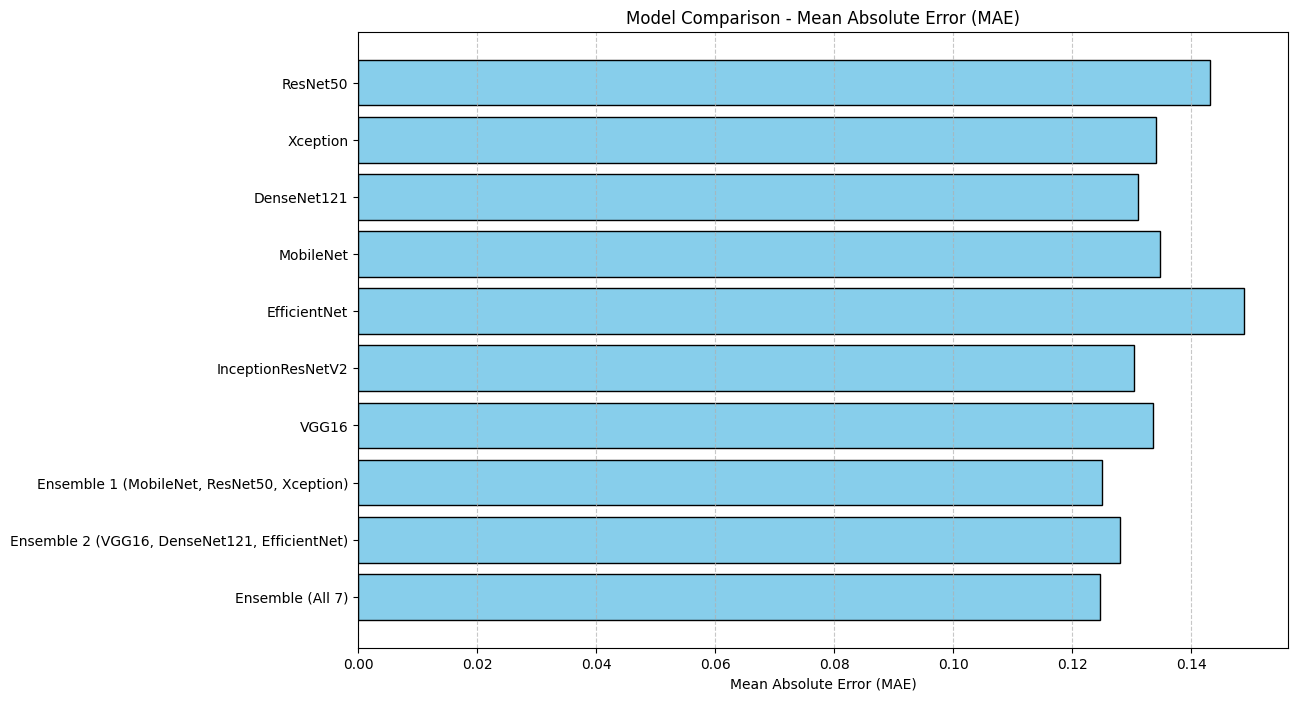

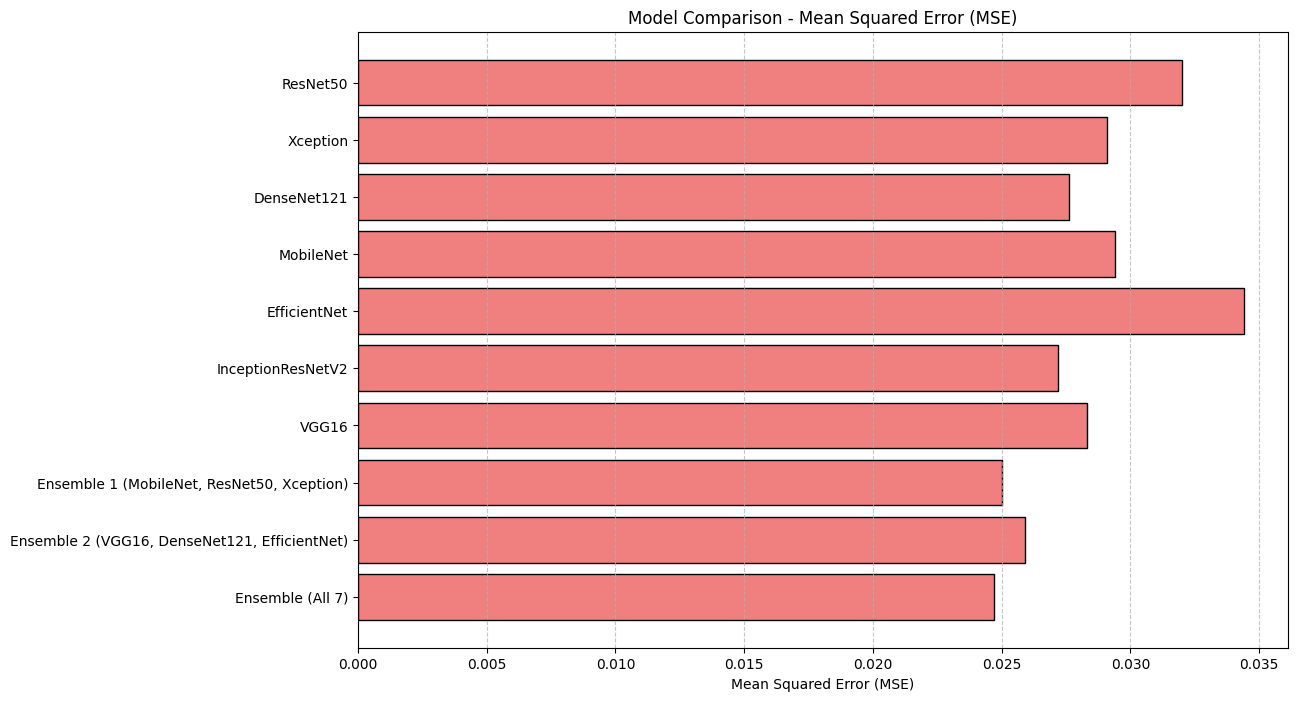

In [ ]:
models = [
    "ResNet50", "Xception", "DenseNet121", "MobileNet", "EfficientNet",
    "InceptionResNetV2", "VGG16", "Ensemble 1 (MobileNet, ResNet50, Xception)",
    "Ensemble 2 (VGG16, DenseNet121, EfficientNet)", "Ensemble (All 7)"
]
mae_values = [
    0.1432, 0.1340, 0.1311, 0.1348, 0.1488,
    0.1303, 0.1336, 0.1250, 0.1280, 0.1246
]
mse_values = [
    0.0320, 0.0291, 0.0276, 0.0294, 0.0344,
    0.0272, 0.0283, 0.0250, 0.0259, 0.0247
]

# Function to plot horizontal bar chart
def plot_horizontal_bar_chart(values, metric_name, color):
    y_pos = np.arange(len(models))
    plt.figure(figsize=(12, 8))
    plt.barh(y_pos, values, color=color, edgecolor='black')
    plt.yticks(y_pos, models)
    plt.xlabel(metric_name)
    plt.title(f'Model Comparison - {metric_name}')
    plt.gca().invert_yaxis()  # Highest values at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Plotting MAE
plot_horizontal_bar_chart(mae_values, 'Mean Absolute Error (MAE)', 'skyblue')

# Plotting MSE
plot_horizontal_bar_chart(mse_values, 'Mean Squared Error (MSE)', 'lightcoral')

In [ ]:
from PIL import Image
import tensorflow as tf
import numpy as np



mobilenet_model = tf.keras.models.load_model('/content/aesthetic_ mobilenet_model.keras')
xception_model = tf.keras.models.load_model('/content/aesthetic_ xception_model.keras')
densenet_model = tf.keras.models.load_model('/content/aesthetic_densnet_model.keras')
efficient_model = tf.keras.models.load_model('/content/aesthetic_efficient_model.keras')
resnet_model = tf.keras.models.load_model('/content/aesthetic_resnet_model.keras')
vgg_model = tf.keras.models.load_model('/content/aesthetic_vgg_model.keras')
inceptionresnetV2_model = tf.keras.models.load_model('/content/aesthetic_model.keras')


Setting up GPU...
TensorFlow version: 2.15.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Evaluating individual models...


Individual models:   0%|          | 0/7 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]


Computing ensemble predictions...

Performance data saved to: model_performance_20241206_120551.json


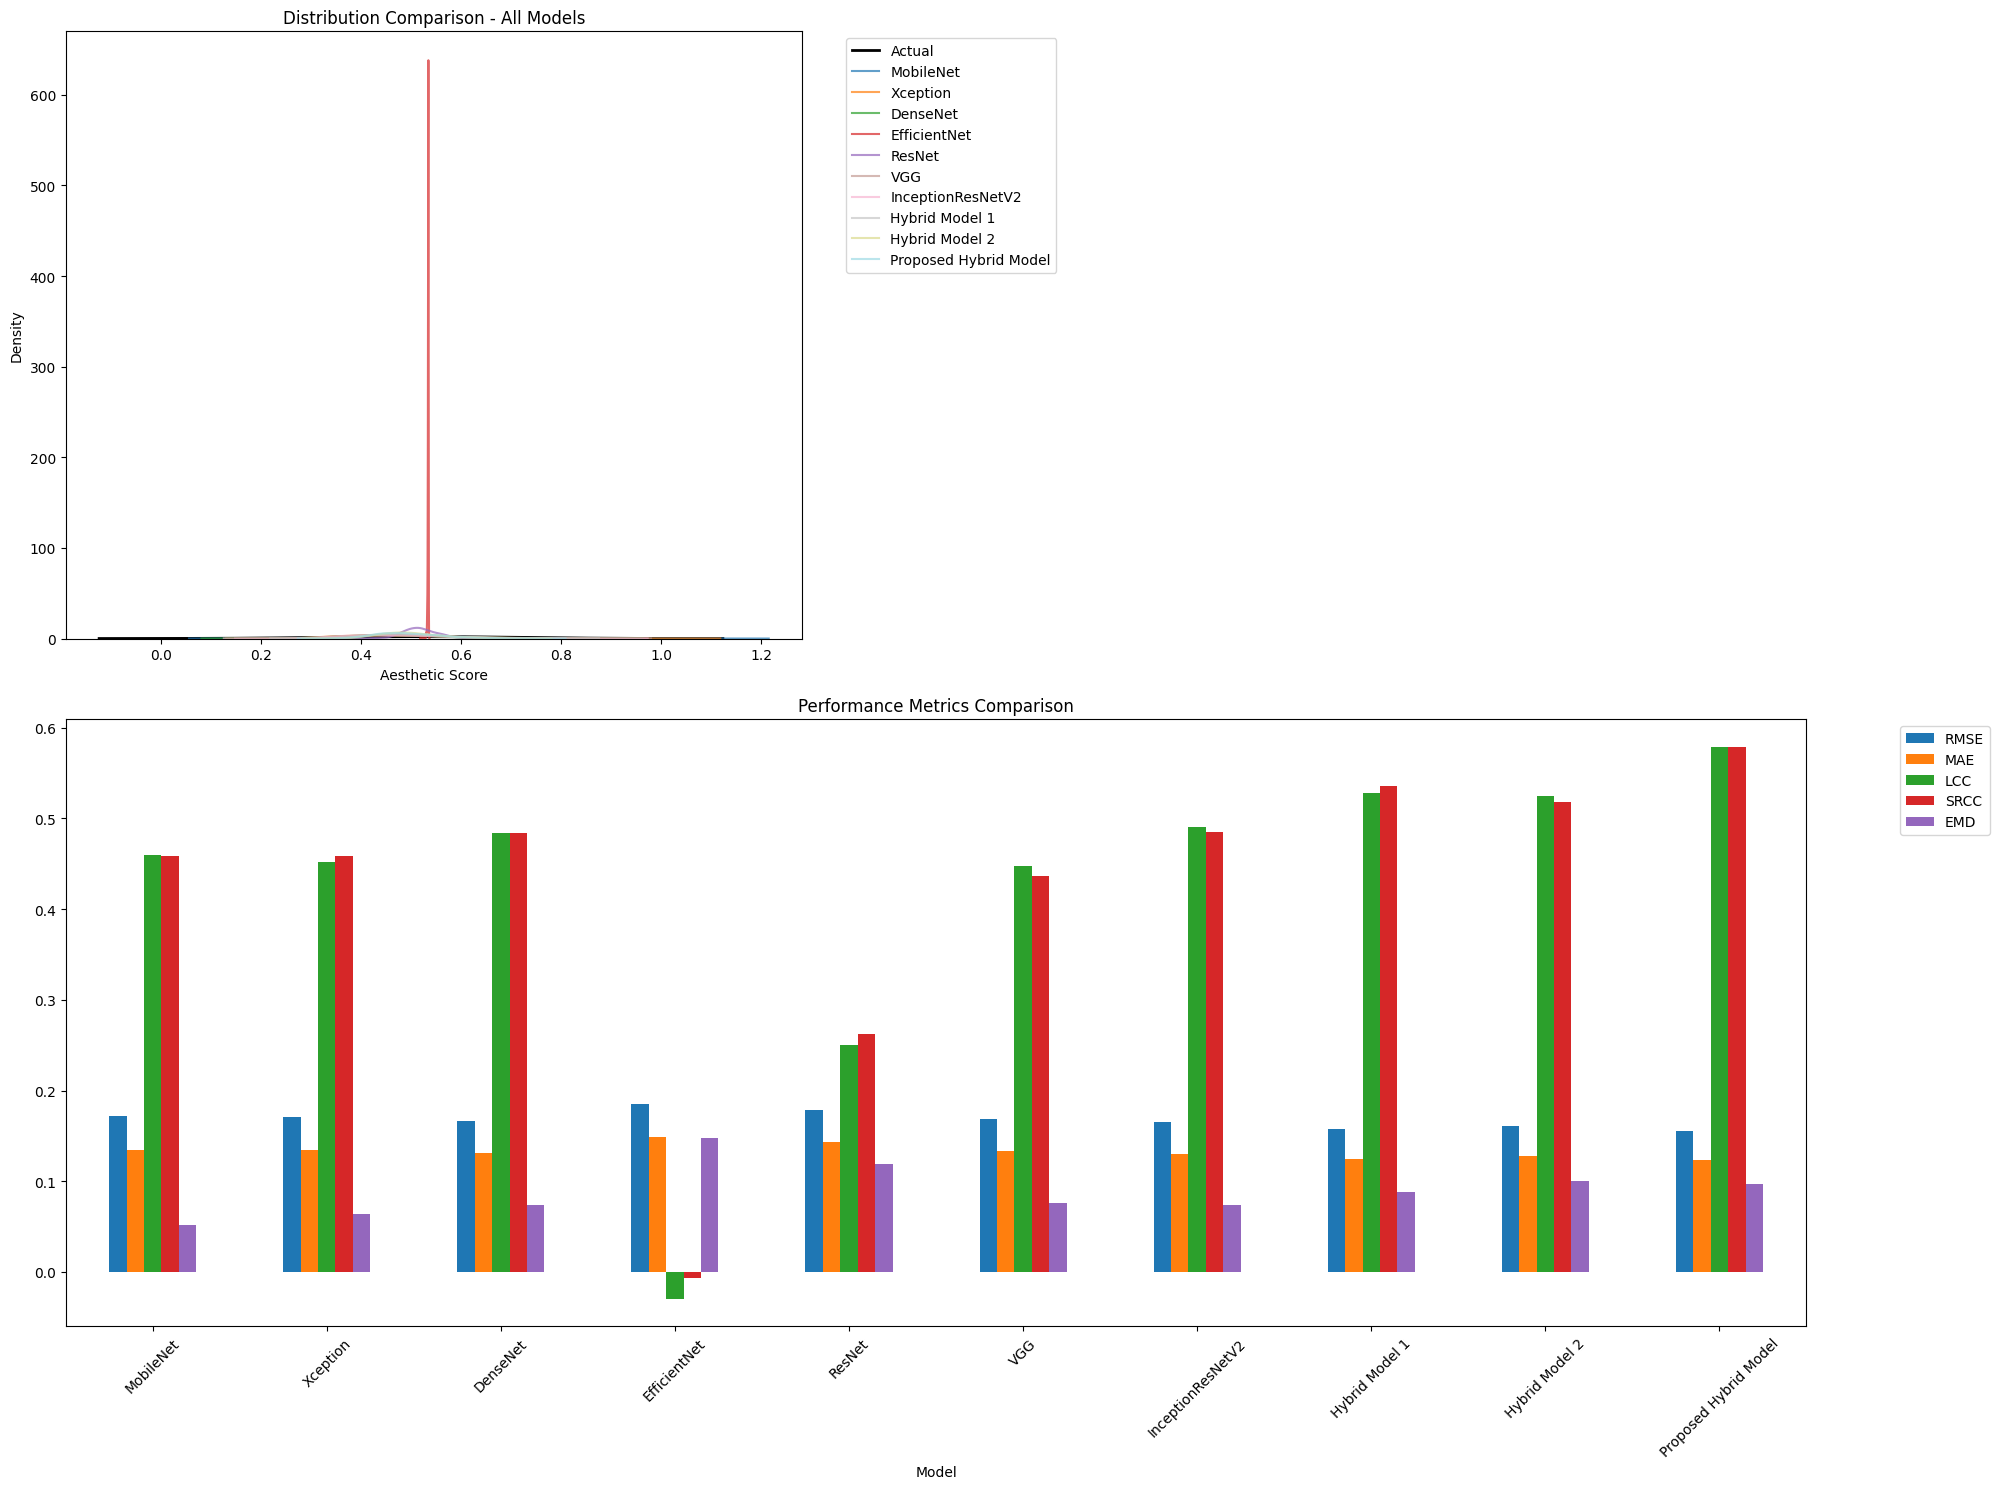


Detailed Performance Metrics:
                         RMSE     MAE     LCC    SRCC     EMD
MobileNet              0.1715  0.1348  0.4596  0.4592  0.0522
Xception               0.1705  0.1340  0.4524  0.4585  0.0644
DenseNet               0.1661  0.1311  0.4845  0.4835  0.0735
EfficientNet           0.1855  0.1488 -0.0295 -0.0062  0.1482
ResNet                 0.1786  0.1430  0.2501  0.2623  0.1193
VGG                    0.1683  0.1336  0.4480  0.4364  0.0761
InceptionResNetV2      0.1649  0.1303  0.4902  0.4854  0.0739
Hybrid Model 1         0.1575  0.1245  0.5285  0.5358  0.0882
Hybrid Model 2         0.1609  0.1281  0.5250  0.5177  0.1008
Proposed Hybrid Model  0.1555  0.1233  0.5788  0.5791  0.0965

Best Models per Metric:
RMSE: Proposed Hybrid Model (0.1555)
MAE: Proposed Hybrid Model (0.1233)
LCC: Proposed Hybrid Model (0.5788)
SRCC: Proposed Hybrid Model (0.5791)
EMD: MobileNet (0.0522)


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, wasserstein_distance
from tqdm.auto import tqdm
import json
from datetime import datetime

def create_dataset(dataframe):
    """Create TensorFlow dataset from dataframe with proper shape handling"""
    image_paths = dataframe['ImageFile'].values
    labels = dataframe['score'].values.reshape(-1, 1)  # Ensure labels are 2D

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def preprocess_wrapper(x, y):
        image_tensor, label_tensor = tf.py_function(
            func=preprocess_image,
            inp=[x, y],
            Tout=[tf.float32, tf.float32]
        )
        image_tensor.set_shape([224, 224, 3])
        label_tensor.set_shape([1])
        return image_tensor, label_tensor

    dataset = dataset.map(preprocess_wrapper)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def evaluate_model_on_dataset(model, dataset, num_samples):
    """Evaluate model using TensorFlow dataset with improved NaN handling"""
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataset, desc="Processing batches"):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            if not isinstance(images, tf.Tensor):
                images = tf.convert_to_tensor(images)

            preds = model.predict(images, verbose=0)
            labels_np = labels.numpy()

            if len(labels_np.shape) == 1:
                labels_np = labels_np.reshape(-1, 1)

            valid_indices = ~np.isnan(labels_np).any(axis=1)
            if np.any(valid_indices):
                all_preds.extend(preds[valid_indices])
                all_labels.extend(labels_np[valid_indices])

    y_pred = np.array(all_preds)
    y_true = np.array(all_labels)

    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask].flatten()
    y_pred_clean = y_pred[mask].flatten()

    emd = wasserstein_distance(y_true_clean, y_pred_clean)

    metrics = {
        'MSE': mean_squared_error(y_true_clean, y_pred_clean),
        'RMSE': np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)),
        'MAE': mean_absolute_error(y_true_clean, y_pred_clean),
        'LCC': pearsonr(y_true_clean, y_pred_clean)[0],
        'SRCC': spearmanr(y_true_clean, y_pred_clean)[0],
        'EMD': emd
    }

    return y_pred_clean, y_true_clean, metrics

def compute_ensemble_predictions(individual_results, model_names, hybrid_model_configs):
    """Compute ensemble predictions using existing individual model predictions with proper type handling"""
    ensemble_results = {}

    for models_list, ensemble_name in hybrid_model_configs:

        ensemble_preds = []
        for model in models_list:
          
            model_idx = [i for i, (m, name) in enumerate(individual_models) if m == model][0]
            model_name = model_names[model_idx]
            ensemble_preds.append(individual_results[model_name])

    
        ensemble_pred = np.mean(ensemble_preds, axis=0)
        ensemble_results[ensemble_name] = ensemble_pred

    return ensemble_results

def save_performance_data(metrics_dict, filename_prefix="model_performance"):
    """Save performance metrics with proper type conversion for JSON"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{filename_prefix}_{timestamp}.json"


    def convert_to_native(obj):
        if isinstance(obj, (np.integer, np.floating)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj


    serializable_dict = {}
    for model_name, metrics in metrics_dict.items():
        serializable_dict[model_name] = {
            k: convert_to_native(v) for k, v in metrics.items()
        }

    with open(filename, 'w') as f:
        json.dump(serializable_dict, f, indent=4)

    return filename

def plot_model_comparisons(individual_models, hybrid_models, test_dataset, num_test_samples, save_results=True):
    """Create comprehensive comparison plots for individual and hybrid models"""
    results = {}
    metrics_dict = {}
    all_true_labels = None
    model_names = [name for _, name in individual_models]


    print("\nEvaluating individual models...")
    for model, name in tqdm(individual_models, desc="Individual models"):
        pred, true_labels, metrics = evaluate_model_on_dataset(model, test_dataset, num_test_samples)
        results[name] = pred
        metrics_dict[name] = metrics
        if all_true_labels is None:
            all_true_labels = true_labels


    print("\nComputing ensemble predictions...")
    ensemble_results = compute_ensemble_predictions(results, model_names, hybrid_models)


    for ensemble_name, ensemble_pred in ensemble_results.items():
        metrics = {
            'MSE': float(mean_squared_error(all_true_labels, ensemble_pred)),
            'RMSE': float(np.sqrt(mean_squared_error(all_true_labels, ensemble_pred))),
            'MAE': float(mean_absolute_error(all_true_labels, ensemble_pred)),
            'LCC': float(pearsonr(all_true_labels, ensemble_pred)[0]),
            'SRCC': float(spearmanr(all_true_labels, ensemble_pred)[0]),
            'EMD': float(wasserstein_distance(all_true_labels, ensemble_pred))
        }
        results[ensemble_name] = ensemble_pred
        metrics_dict[ensemble_name] = metrics

    if save_results:
        saved_file = save_performance_data(metrics_dict)
        print(f"\nPerformance data saved to: {saved_file}")

    fig = plt.figure(figsize=(20, 15))


    plt.subplot(2, 2, 1)
    sns.kdeplot(data=all_true_labels, label='Actual', color='black', linewidth=2)
    colors = plt.cm.tab20(np.linspace(0, 1, len(results)))

    for (name, pred), color in zip(results.items(), colors):
        sns.kdeplot(data=pred, label=name, color=color, alpha=0.7)

    plt.title('Distribution Comparison - All Models', fontsize=12)
    plt.xlabel('Aesthetic Score')
    plt.ylabel('Density')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


    plt.subplot(2, 2, (3, 4))
    metrics_df = pd.DataFrame(metrics_dict).T

    metrics_to_plot = ['RMSE', 'MAE', 'LCC', 'SRCC', 'EMD']
    metrics_df[metrics_to_plot].plot(kind='bar', ax=plt.gca())
    plt.title('Performance Metrics Comparison')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


    print("\nDetailed Performance Metrics:")
    print("=" * 80)
    metrics_df_display = metrics_df[metrics_to_plot].round(4)
    print(metrics_df_display)


    print("\nBest Models per Metric:")
    print("=" * 80)
    for metric in metrics_to_plot:
        if metric in ['RMSE', 'MAE', 'EMD']:  
            best_model = metrics_df[metric].idxmin()
            best_value = metrics_df[metric].min()
        else: 
            best_model = metrics_df[metric].idxmax()
            best_value = metrics_df[metric].max()
        print(f"{metric}: {best_model} ({best_value:.4f})")

# Example usage
if __name__ == "__main__":
    print("\nSetting up GPU...")
    print(f"TensorFlow version: {tf.__version__}")
    print("GPU Available: ", tf.config.list_physical_devices('GPU'))

    # Define your models
    individual_models = [
        (mobilenet_model, "MobileNet"),
        (xception_model, "Xception"),
        (densenet_model, "DenseNet"),
        (efficient_model, "EfficientNet"),
        (resnet_model, "ResNet"),
        (vgg_model, "VGG"),
        (inceptionresnetV2_model, "InceptionResNetV2")
    ]

    hybrid_models = [
        ([resnet_model, xception_model, mobilenet_model], "Hybrid Model 1"),
        ([densenet_model, efficient_model, vgg_model], "Hybrid Model 2"),
        ([densenet_model, efficient_model, vgg_model, resnet_model,
          xception_model, mobilenet_model, inceptionresnetV2_model], "Proposed Hybrid Model")
    ]
    test_dataset = create_dataset(val_df)
    num_test_samples = len(val_df)


    plot_model_comparisons(individual_models, hybrid_models, test_dataset, num_test_samples)


Setting up GPU...
TensorFlow version: 2.15.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Evaluating individual models...


Individual models:   0%|          | 0/7 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]

Processing batches:   0%|          | 0/56 [00:00<?, ?it/s]


Computing ensemble predictions...

Performance data saved to: model_performance_20241206_122550.json


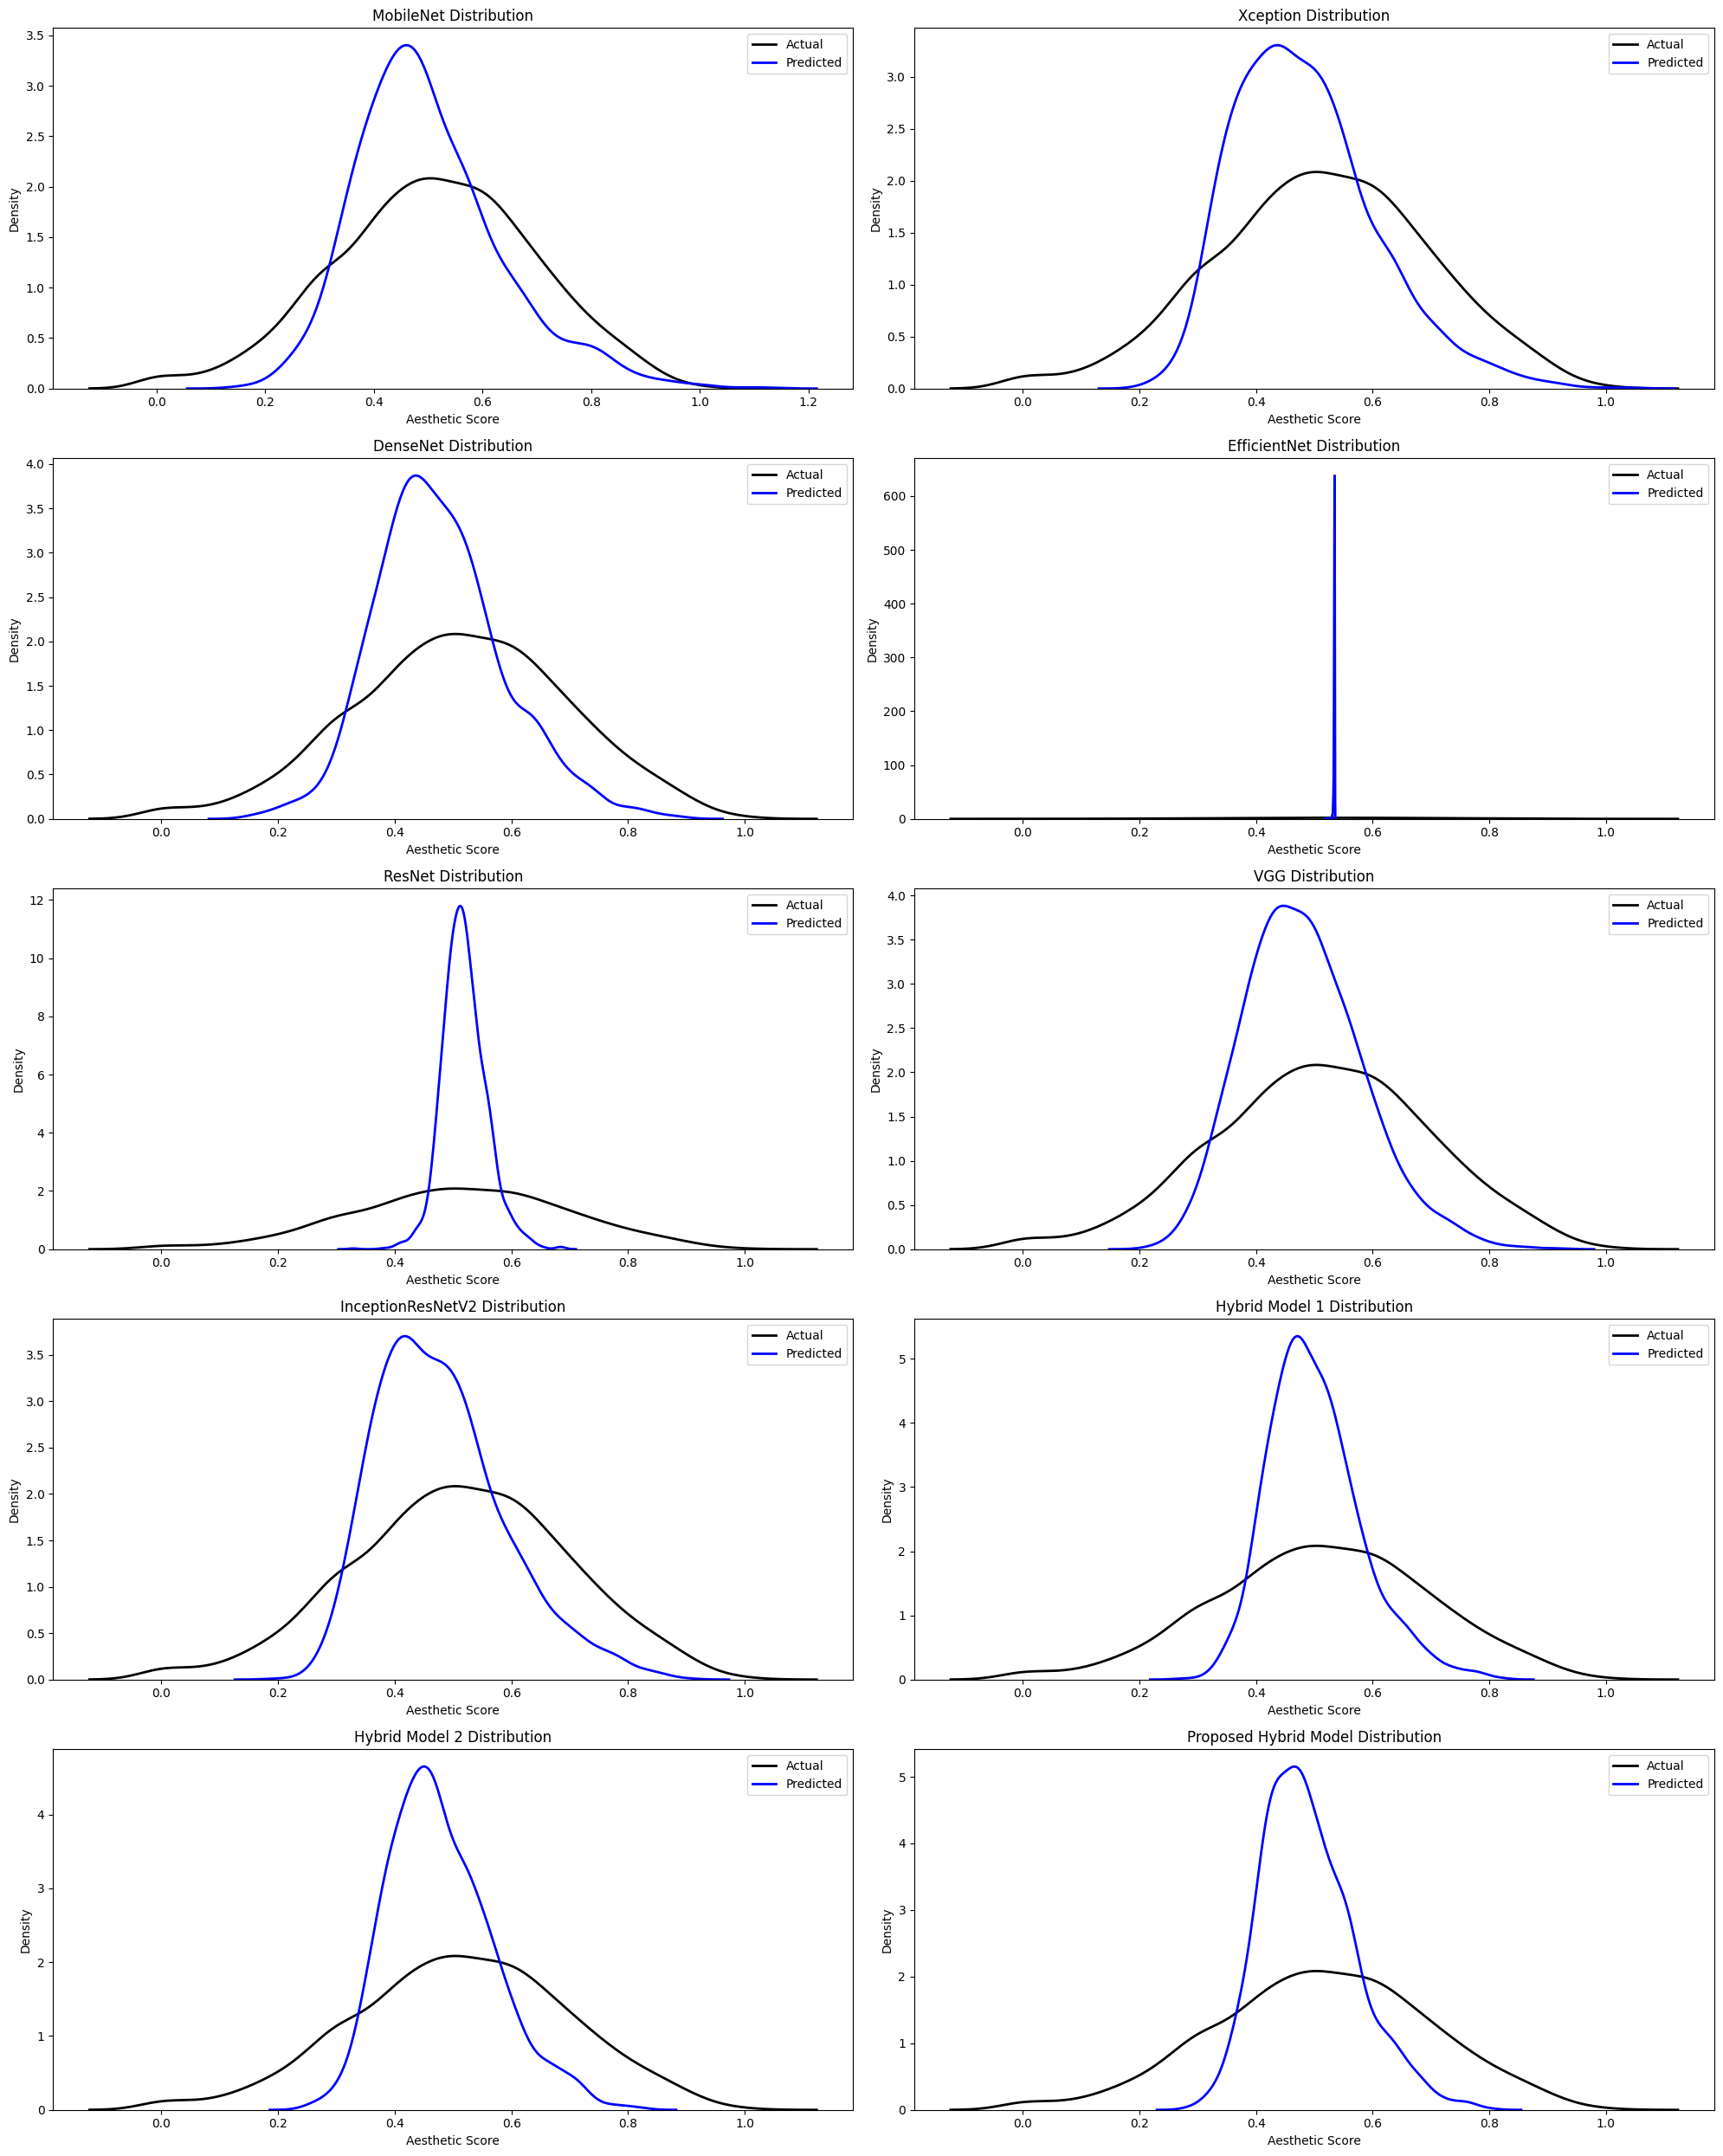

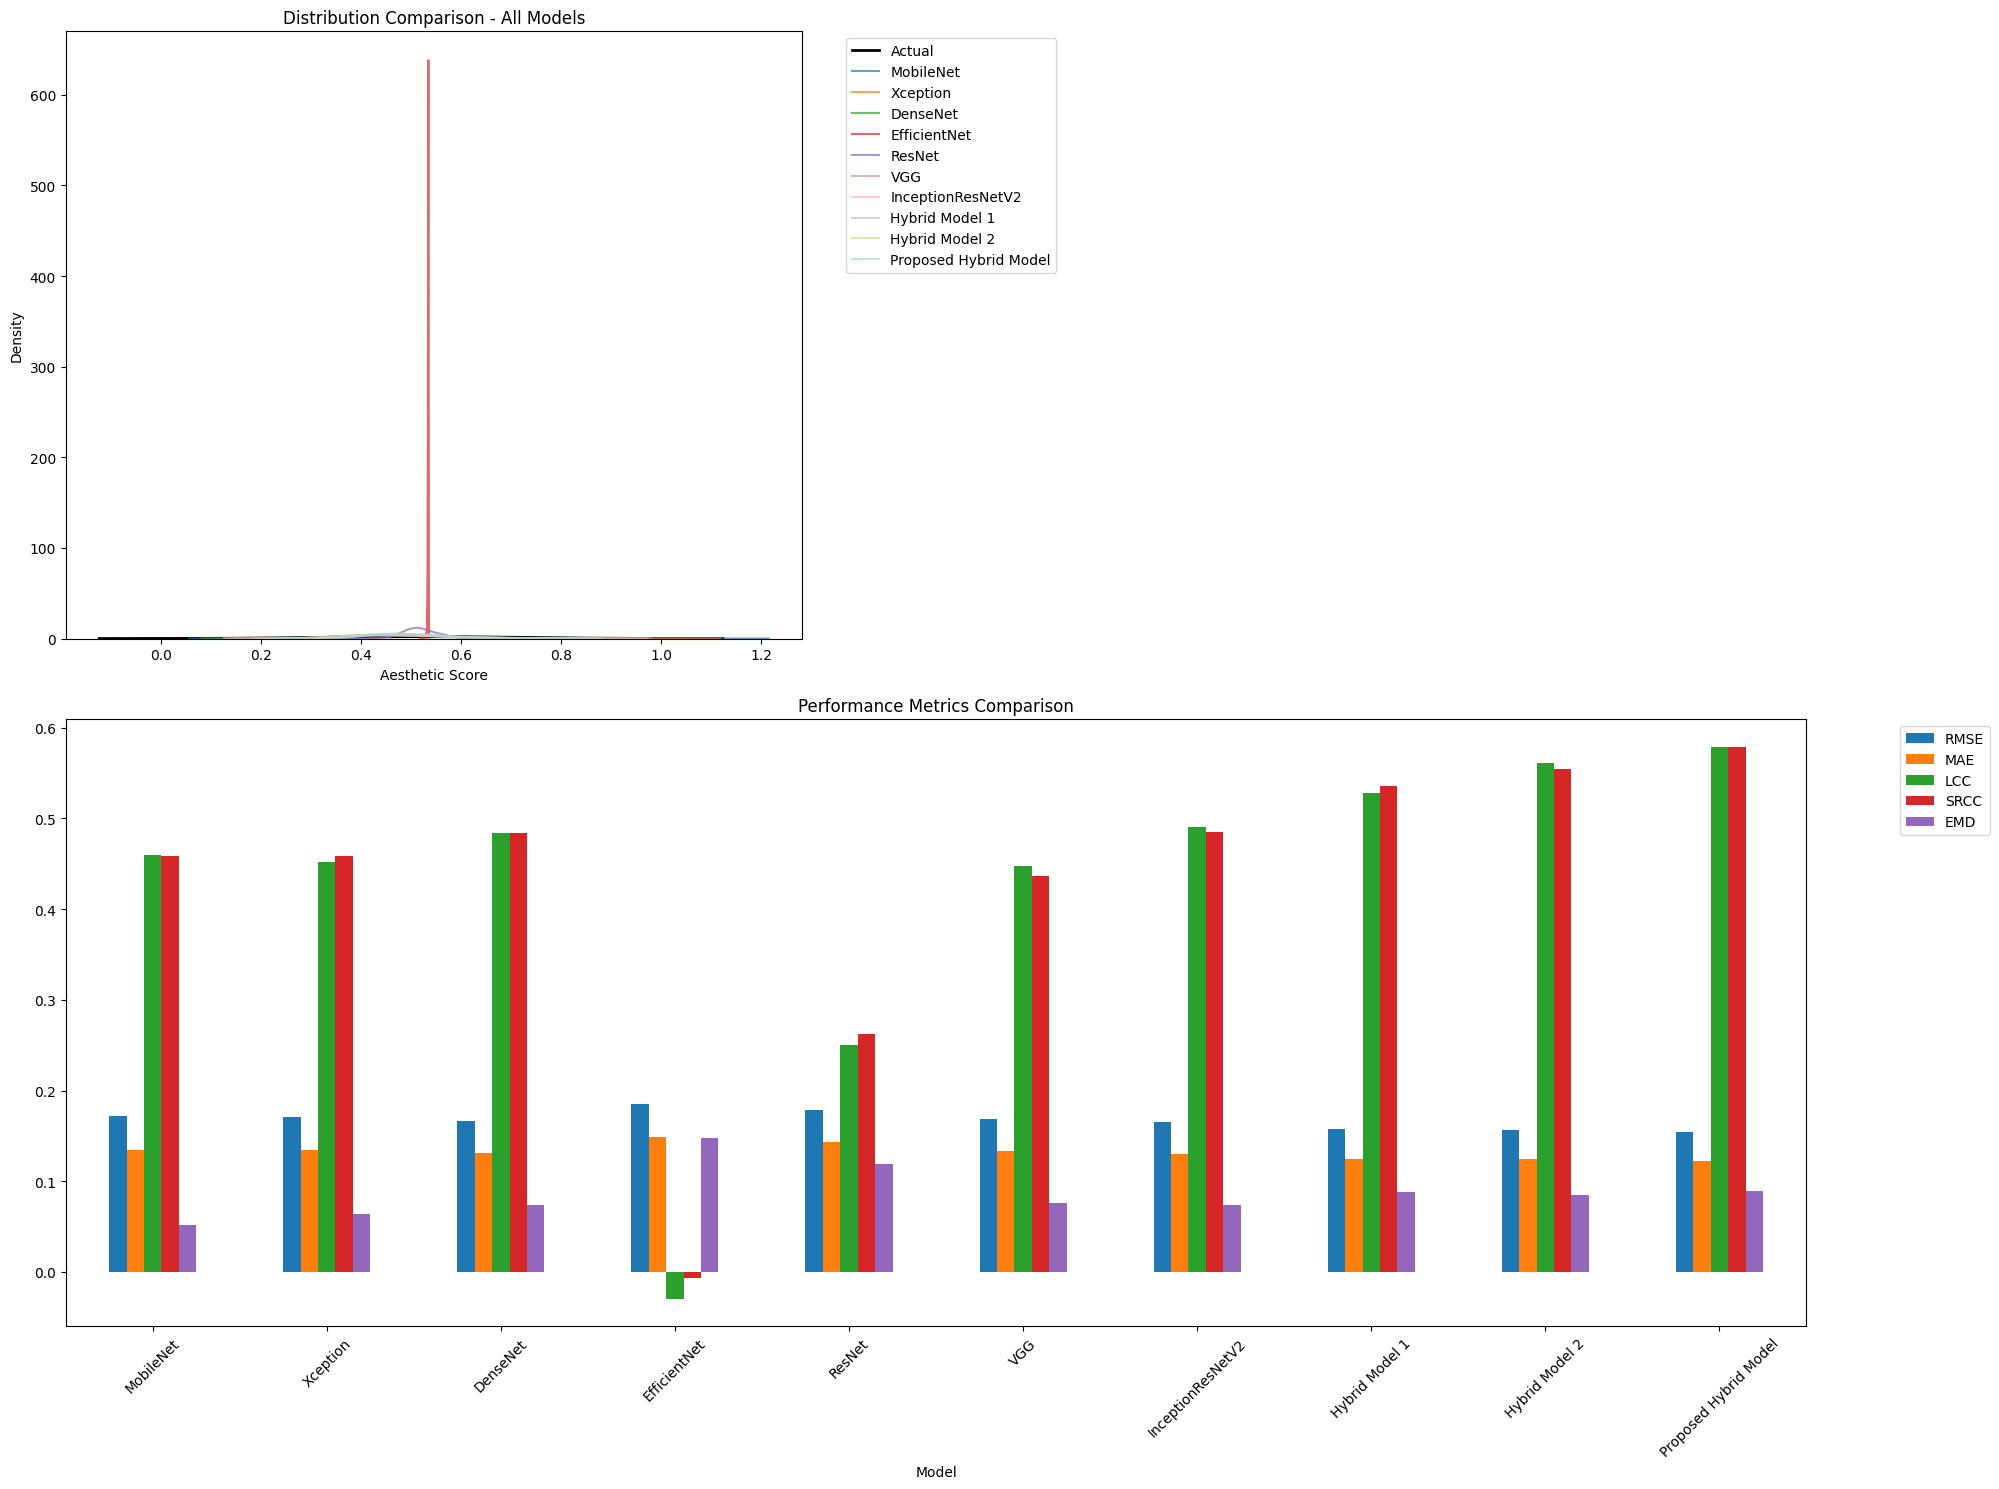


Detailed Performance Metrics:
                         RMSE     MAE     LCC    SRCC     EMD
MobileNet              0.1715  0.1348  0.4596  0.4592  0.0522
Xception               0.1705  0.1340  0.4524  0.4585  0.0644
DenseNet               0.1661  0.1311  0.4845  0.4835  0.0735
EfficientNet           0.1855  0.1488 -0.0295 -0.0062  0.1482
ResNet                 0.1786  0.1430  0.2501  0.2623  0.1193
VGG                    0.1683  0.1336  0.4480  0.4364  0.0761
InceptionResNetV2      0.1649  0.1303  0.4902  0.4854  0.0739
Hybrid Model 1         0.1575  0.1245  0.5285  0.5358  0.0882
Hybrid Model 2         0.1563  0.1243  0.5611  0.5549  0.0853
Proposed Hybrid Model  0.1538  0.1219  0.5788  0.5791  0.0892

Best Models per Metric:
RMSE: Proposed Hybrid Model (0.1538)
MAE: Proposed Hybrid Model (0.1219)
LCC: Proposed Hybrid Model (0.5788)
SRCC: Proposed Hybrid Model (0.5791)
EMD: MobileNet (0.0522)


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, wasserstein_distance
from tqdm.auto import tqdm
import json
from datetime import datetime

def create_dataset(dataframe):
    """Create TensorFlow dataset from dataframe with proper shape handling"""
    image_paths = dataframe['ImageFile'].values
    labels = dataframe['score'].values.reshape(-1, 1)  # Ensure labels are 2D

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def preprocess_wrapper(x, y):
        image_tensor, label_tensor = tf.py_function(
            func=preprocess_image,
            inp=[x, y],
            Tout=[tf.float32, tf.float32]
        )
        image_tensor.set_shape([224, 224, 3])
        label_tensor.set_shape([1])
        return image_tensor, label_tensor

    dataset = dataset.map(preprocess_wrapper)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def evaluate_model_on_dataset(model, dataset, num_samples):
    """Evaluate model using TensorFlow dataset with improved NaN handling"""
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataset, desc="Processing batches"):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            if not isinstance(images, tf.Tensor):
                images = tf.convert_to_tensor(images)

            preds = model.predict(images, verbose=0)
            labels_np = labels.numpy()

            if len(labels_np.shape) == 1:
                labels_np = labels_np.reshape(-1, 1)

            valid_indices = ~np.isnan(labels_np).any(axis=1)
            if np.any(valid_indices):
                all_preds.extend(preds[valid_indices])
                all_labels.extend(labels_np[valid_indices])

    y_pred = np.array(all_preds)
    y_true = np.array(all_labels)

    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask].flatten()
    y_pred_clean = y_pred[mask].flatten()

    emd = wasserstein_distance(y_true_clean, y_pred_clean)

    metrics = {
        'MSE': mean_squared_error(y_true_clean, y_pred_clean),
        'RMSE': np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)),
        'MAE': mean_absolute_error(y_true_clean, y_pred_clean),
        'LCC': pearsonr(y_true_clean, y_pred_clean)[0],
        'SRCC': spearmanr(y_true_clean, y_pred_clean)[0],
        'EMD': emd
    }

    return y_pred_clean, y_true_clean, metrics

def compute_ensemble_predictions(individual_results, model_names, hybrid_model_configs):
    """Compute ensemble predictions using existing individual model predictions with proper type handling"""
    ensemble_results = {}

    for models_list, ensemble_name in hybrid_model_configs:
        # Get the predictions for each model in the ensemble
        ensemble_preds = []
        for model in models_list:
            # Find the model name in individual_results
            model_idx = [i for i, (m, name) in enumerate(individual_models) if m == model][0]
            model_name = model_names[model_idx]
            ensemble_preds.append(individual_results[model_name])

        # Compute mean prediction
        ensemble_pred = np.mean(ensemble_preds, axis=0)
        ensemble_results[ensemble_name] = ensemble_pred

    return ensemble_results

def save_performance_data(metrics_dict, filename_prefix="model_performance"):
    """Save performance metrics with proper type conversion for JSON"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{filename_prefix}_{timestamp}.json"

    # Convert numpy types to Python native types
    def convert_to_native(obj):
        if isinstance(obj, (np.integer, np.floating)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj

    # Convert all metrics to native Python types
    serializable_dict = {}
    for model_name, metrics in metrics_dict.items():
        serializable_dict[model_name] = {
            k: convert_to_native(v) for k, v in metrics.items()
        }

    with open(filename, 'w') as f:
        json.dump(serializable_dict, f, indent=4)

    return filename

def plot_model_comparisons(individual_models, hybrid_models, test_dataset, num_test_samples, save_results=True):
    """Create comprehensive comparison plots for individual and hybrid models"""
    results = {}
    metrics_dict = {}
    all_true_labels = None
    model_names = [name for _, name in individual_models]

    # Evaluate individual models
    print("\nEvaluating individual models...")
    for model, name in tqdm(individual_models, desc="Individual models"):
        pred, true_labels, metrics = evaluate_model_on_dataset(model, test_dataset, num_test_samples)
        results[name] = pred
        metrics_dict[name] = metrics
        if all_true_labels is None:
            all_true_labels = true_labels

    # Compute ensemble predictions using individual results
    print("\nComputing ensemble predictions...")
    ensemble_results = compute_ensemble_predictions(results, model_names, hybrid_models)

    # Calculate metrics for ensemble models
    for ensemble_name, ensemble_pred in ensemble_results.items():
        metrics = {
            'MSE': float(mean_squared_error(all_true_labels, ensemble_pred)),
            'RMSE': float(np.sqrt(mean_squared_error(all_true_labels, ensemble_pred))),
            'MAE': float(mean_absolute_error(all_true_labels, ensemble_pred)),
            'LCC': float(pearsonr(all_true_labels, ensemble_pred)[0]),
            'SRCC': float(spearmanr(all_true_labels, ensemble_pred)[0]),
            'EMD': float(wasserstein_distance(all_true_labels, ensemble_pred))
        }
        results[ensemble_name] = ensemble_pred
        metrics_dict[ensemble_name] = metrics

    if save_results:
        saved_file = save_performance_data(metrics_dict)
        print(f"\nPerformance data saved to: {saved_file}")

    # Create individual KDE plots
    n_models = len(results)
    n_cols = 2
    n_rows = (n_models + 1) // 2
    fig_individual = plt.figure(figsize=(20, 5*n_rows))

    for idx, (model_name, pred) in enumerate(results.items(), 1):
        plt.subplot(n_rows, n_cols, idx)
        sns.kdeplot(data=all_true_labels, label='Actual', color='black', linewidth=2)
        sns.kdeplot(data=pred, label='Predicted', color='blue', linewidth=2)

        plt.title(f'{model_name} Distribution', fontsize=12)
        plt.xlabel('Aesthetic Score')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Original combined plot
    fig = plt.figure(figsize=(20, 15))

    # 1. Combined KDE plot
    plt.subplot(2, 2, 1)
    sns.kdeplot(data=all_true_labels, label='Actual', color='black', linewidth=2)
    colors = plt.cm.tab20(np.linspace(0, 1, len(results)))

    for (name, pred), color in zip(results.items(), colors):
        sns.kdeplot(data=pred, label=name, color=color, alpha=0.7)

    plt.title('Distribution Comparison - All Models', fontsize=12)
    plt.xlabel('Aesthetic Score')
    plt.ylabel('Density')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Performance Metrics Comparison
    plt.subplot(2, 2, (3, 4))
    metrics_df = pd.DataFrame(metrics_dict).T

    metrics_to_plot = ['RMSE', 'MAE', 'LCC', 'SRCC', 'EMD']
    metrics_df[metrics_to_plot].plot(kind='bar', ax=plt.gca())
    plt.title('Performance Metrics Comparison')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\nDetailed Performance Metrics:")
    print("=" * 80)
    metrics_df_display = metrics_df[metrics_to_plot].round(4)
    print(metrics_df_display)

    # Print best model for each metric
    print("\nBest Models per Metric:")
    print("=" * 80)
    for metric in metrics_to_plot:
        if metric in ['RMSE', 'MAE', 'EMD']:  # Lower is better
            best_model = metrics_df[metric].idxmin()
            best_value = metrics_df[metric].min()
        else:  # Higher is better for LCC and SRCC
            best_model = metrics_df[metric].idxmax()
            best_value = metrics_df[metric].max()
        print(f"{metric}: {best_model} ({best_value:.4f})")

# Example usage
if __name__ == "__main__":
    print("\nSetting up GPU...")
    print(f"TensorFlow version: {tf.__version__}")
    print("GPU Available: ", tf.config.list_physical_devices('GPU'))

    # Define your models
    individual_models = [
        (mobilenet_model, "MobileNet"),
        (xception_model, "Xception"),
        (densenet_model, "DenseNet"),
        (efficient_model, "EfficientNet"),
        (resnet_model, "ResNet"),
        (vgg_model, "VGG"),
        (inceptionresnetV2_model, "InceptionResNetV2")
    ]

    hybrid_models = [
        ([resnet_model, xception_model, mobilenet_model], "Hybrid Model 1"),
        ([densenet_model, efficient_model, vgg_model], "Hybrid Model 2"),
        ([densenet_model, efficient_model, vgg_model, resnet_model,
          xception_model, mobilenet_model, inceptionresnetV2_model], "Proposed Hybrid Model")
    ]

    # Create dataset
    test_dataset = create_dataset(val_df)
    num_test_samples = len(val_df)

    # Run comparison
    plot_model_comparisons(individual_models, hybrid_models, test_dataset, num_test_samples)

In [ ]:
import tensorflow as tf
import time
import numpy as np
import cv2  

def preprocess_image(image_path, target_size=(224, 224)):
    """Preprocess a single image"""
  
    image = cv2.imread(image_path)
   
    image = cv2.resize(image, target_size)

    image = image.astype('float32') / 255.0

    image = np.expand_dims(image, axis=0)
    return image

def evaluate_inference_time(model, image_path):
    """Measure the time taken for preprocessing and inference on a single image"""


    start_time = time.time()
    image = preprocess_image(image_path)
    preprocessing_time = time.time() - start_time
    print(f"Preprocessing time: {preprocessing_time:.4f} seconds")


    start_time = time.time()
    predictions = model.predict(image, verbose=0)
    inference_time = time.time() - start_time
    print(f"Inference time: {inference_time:.4f} seconds")

    return preprocessing_time, inference_time

def evaluate_ensemble_inference_time(models, image_path):
    """Measure the time taken for an ensemble (hybrid) model"""


    start_time = time.time()
    image = preprocess_image(image_path)
    preprocessing_time = time.time() - start_time


    start_time = time.time()
    ensemble_preds = np.mean([model.predict(image, verbose=0) for model in models], axis=0)
    inference_time = time.time() - start_time

    print(f"Preprocessing time: {preprocessing_time:.4f} seconds")
    print(f"Ensemble Inference time: {inference_time:.4f} seconds")

    return preprocessing_time, inference_time

def evaluate_models_on_single_image(models, image_path):
    """Evaluate multiple models (individual and hybrid) and measure their time complexity"""
    results = {}

    for model, name in models:
        print(f"\nEvaluating {name}...")
        preprocessing_time, inference_time = evaluate_inference_time(model, image_path)
        results[name] = {
            "Preprocessing Time": preprocessing_time,
            "Inference Time": inference_time,
            "Total Time": preprocessing_time + inference_time
        }

    return results

def evaluate_hybrid_models_on_single_image(hybrid_models, image_path):
    """Evaluate hybrid (ensemble) models and measure their time complexity"""
    hybrid_results = {}

    for hybrid_model, name in hybrid_models:
        print(f"\nEvaluating Hybrid Model: {name}...")
        preprocessing_time, inference_time = evaluate_ensemble_inference_time(hybrid_model, image_path)
        hybrid_results[name] = {
            "Preprocessing Time": preprocessing_time,
            "Inference Time": inference_time,
            "Total Time": preprocessing_time + inference_time
        }

    return hybrid_results

def main():




    individual_models = [
        (mobilenet_model, "MobileNet"),
        (xception_model, "Xception"),
        (densenet_model, "DenseNet"),
        (efficient_model, "EfficientNet"),
        (resnet_model, "ResNet"),
        (vgg_model, "VGG"),
        (inceptionresnetV2_model, "InceptionResNetV2")
    ]

    
    hybrid_models = [
        ([mobilenet_model, xception_model, resnet_model], "Hybrid Model 1"),
        ([densenet_model, efficient_model, vgg_model], "Hybrid Model 2"),
        ([mobilenet_model, xception_model, resnet_model, densenet_model,
          efficient_model, vgg_model, inceptionresnetV2_model], "Proposed Hybrid Model")
    ]

   
    image_path = '/content/AADB Dataset/datasetImages_warp256/datasetImages_warp256/farm1_255_19452343093_8ee7e5e375_b.jpg'  # Replace with the actual image path

    print("\nEvaluating Individual Models...")
    individual_results = evaluate_models_on_single_image(individual_models, image_path)

    print("\nEvaluating Hybrid Models...")
    hybrid_results = evaluate_hybrid_models_on_single_image(hybrid_models, image_path)


    print("\nIndividual Model Performance Times:")
    print("=" * 40)
    for model_name, times in individual_results.items():
        print(f"{model_name}:")
        for time_type, time_value in times.items():
            print(f"  {time_type}: {time_value:.4f} seconds")
        print("-" * 40)


    print("\nHybrid Model Performance Times:")
    print("=" * 40)
    for hybrid_name, times in hybrid_results.items():
        print(f"{hybrid_name}:")
        for time_type, time_value in times.items():
            print(f"  {time_type}: {time_value:.4f} seconds")
        print("-" * 40)

if __name__ == "__main__":
    main()



Evaluating Individual Models...

Evaluating MobileNet...
Preprocessing time: 0.0403 seconds
Inference time: 2.3173 seconds

Evaluating Xception...
Preprocessing time: 0.0024 seconds
Inference time: 1.7798 seconds

Evaluating DenseNet...
Preprocessing time: 0.0015 seconds
Inference time: 3.5271 seconds

Evaluating EfficientNet...
Preprocessing time: 0.0014 seconds
Inference time: 3.0405 seconds

Evaluating ResNet...
Preprocessing time: 0.0017 seconds


Inference time: 1.5377 seconds

Evaluating VGG...
Preprocessing time: 0.0020 seconds


Inference time: 1.0296 seconds

Evaluating InceptionResNetV2...
Preprocessing time: 0.0020 seconds
Inference time: 5.3303 seconds

Evaluating Hybrid Models...

Evaluating Hybrid Model: Hybrid Model 1...
Preprocessing time: 0.0020 seconds
Ensemble Inference time: 0.3021 seconds

Evaluating Hybrid Model: Hybrid Model 2...
Preprocessing time: 0.0013 seconds
Ensemble Inference time: 0.3117 seconds

Evaluating Hybrid Model: Proposed Hybrid Model...
Preprocessing time: 0.0021 seconds
Ensemble Inference time: 0.7367 seconds

Individual Model Performance Times:
MobileNet:
  Preprocessing Time: 0.0403 seconds
  Inference Time: 2.3173 seconds
  Total Time: 2.3576 seconds
----------------------------------------
Xception:
  Preprocessing Time: 0.0024 seconds
  Inference Time: 1.7798 seconds
  Total Time: 1.7822 seconds
----------------------------------------
DenseNet:
  Preprocessing Time: 0.0015 seconds
  Inference Time: 3.5271 seconds
  Total Time: 3.5287 seconds
------------------------------


Model Inference Time Comparison:
            Model  Time (seconds)       Type
              VGG          1.0296 Individual
           ResNet          1.5377 Individual
         Xception          1.7798 Individual
        MobileNet          2.3173 Individual
     EfficientNet          3.0405 Individual
         DenseNet          3.5271 Individual
InceptionResNetV2          5.3303 Individual
   Hybrid Model 1          5.9369     Hybrid
   Hybrid Model 2          7.9089     Hybrid
  Proposed Hybrid         19.2990     Hybrid


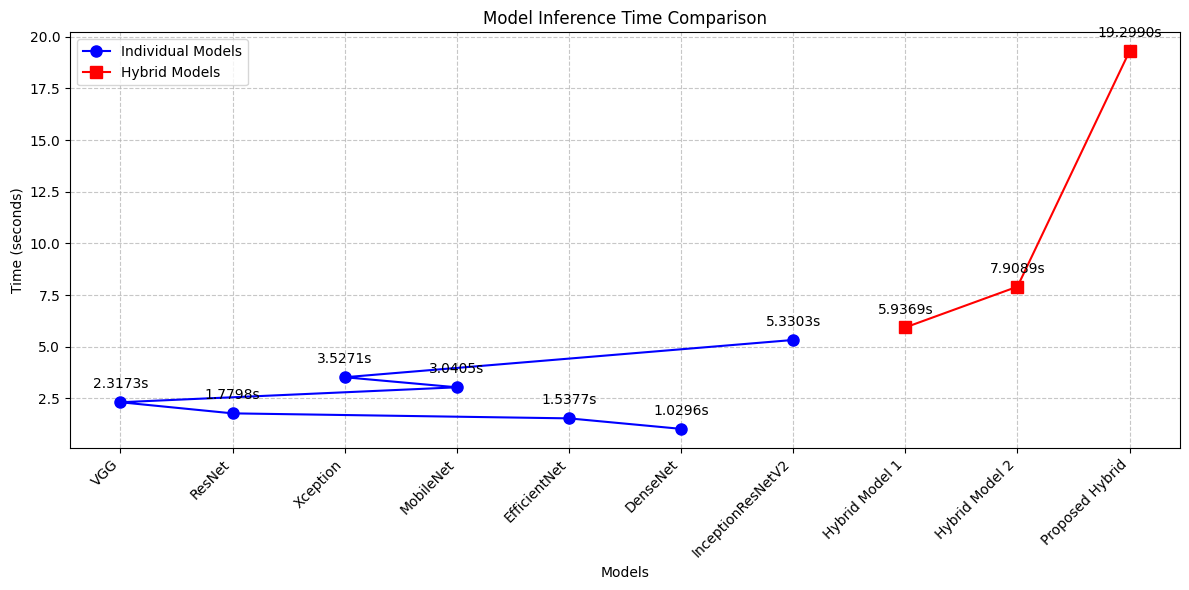

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


individual_times = {
    'MobileNet': 2.3173,
    'Xception': 1.7798,
    'DenseNet': 3.5271,
    'EfficientNet': 3.0405,
    'ResNet': 1.5377,
    'VGG': 1.0296,
    'InceptionResNetV2': 5.3303
}


hybrid_total_times = {
    'Hybrid Model 1': sum([2.3173, 1.7798, 1.5377]) + 0.3021,  
    'Hybrid Model 2': sum([3.5271, 3.0405, 1.0296]) + 0.3117, 
    'Proposed Hybrid': sum([2.3173, 1.7798, 1.5377, 3.5271, 3.0405, 1.0296, 5.3303]) + 0.7367  
}

def create_comparison_table():
    # Combine all times into one table
    data = {
        'Model': list(individual_times.keys()) + list(hybrid_total_times.keys()),
        'Time (seconds)': list(individual_times.values()) + list(hybrid_total_times.values()),
        'Type': ['Individual']*len(individual_times) + ['Hybrid']*len(hybrid_total_times)
    }
    
    df = pd.DataFrame(data)
    df = df.sort_values('Time (seconds)')
    
    print("\nModel Inference Time Comparison:")
    print("=" * 60)
    print(df.to_string(index=False))
    
    return df

def create_comparison_plot(df):
    plt.figure(figsize=(12, 6))
    

    individual_df = df[df['Type'] == 'Individual']
    hybrid_df = df[df['Type'] == 'Hybrid']
    

    x = range(len(df))
    plt.plot(individual_df.index, individual_df['Time (seconds)'], 'bo-', label='Individual Models', markersize=8)
    plt.plot(hybrid_df.index, hybrid_df['Time (seconds)'], 'rs-', label='Hybrid Models', markersize=8)
    
    # Customize plot
    plt.xlabel('Models')
    plt.ylabel('Time (seconds)')
    plt.title('Model Inference Time Comparison')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-ticks to model names
    plt.xticks(x, df['Model'], rotation=45, ha='right')
    
    # Add value labels
    for i, row in df.iterrows():
        plt.annotate(f"{row['Time (seconds)']:.4f}s", 
                    (i, row['Time (seconds)']), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df = create_comparison_table()
    create_comparison_plot(df)